summary: Multiple visits using condition table

v1

Table1 using dataset v7

v2

Location, lenght of stay, current age at visit added

v3

type of diagnosis, payer according to date, expand to J45.9 and J46

v4

Separation between moderate and severe (requested by Tesfaye)

Comorbidities
1. G47.3 Sleep apnea
2. E66.0, E66.2, E66.3, E66.8, E66.9 Obesity
3. J30.x Allergic rhinitis
4. K20.0 EoE
5. K21.x Gastro-esophageal reflux disease
6. L20.x AD
7. Z91.01 Z91.02  Food/Food additives allergy status

v5

additional comorbidities

1. G47.3 Sleep apnea
2. E66.0, E66.2, E66.3, E66.8, E66.9 Obesity
3. J30.x Allergic rhinitis
4. K20.0 EoE
5. K21.x Gastro-esophageal reflux disease
6. L20.x AD
7. Z91.01 Z91.02  Food/Food additives allergy status
8. E11.x Type 2 Diabetes
9. I10.x Hypertension
10. I25.x CIHD
11. J44.x COPD
12. F32.x and F33.x Depression
13. C00x-D49 Neoplasm (Cancer)
14. N18.x Chronic Kidney Disease (CKD)

v6

type of diagnosis, payer according to date, expand to J45.x and 493

v7

Psoriasis added
fields clean up

v8
Health insurance info collapsed and added

In [1]:
!pip install statannot --upgrade --ignore-installed
!pip install tableone

  Using cached statannot-0.2.3-py3-none-any.whl (10 kB)

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statannot import add_stat_annotation
from tableone import TableOne, load_dataset

In [3]:
bucket = os.getenv("WORKSPACE_BUCKET")
bucket
dataset = os.getenv("WORKSPACE_CDR")
print("bucked:{0} dataset:{1}".format(bucket,dataset))

bucked:gs://fc-secure-44ec839e-73ca-4155-bb97-9cdc03614efa dataset:fc-aou-cdr-prod-ct.C2022Q4R9


# Prepare data

## Full population

Population:

In [4]:
# WGS
wgs_pop_sql = f"""
SELECT  person.person_id,
        p_gender_concept.concept_name as gender,
        p_race_concept.concept_name as race,
        p_ethnicity_concept.concept_name as ethnicity,
        p_sex_at_birth_concept.concept_name as sex_at_birth,
        person.birth_datetime as birth_datetime
    FROM
        `{dataset}.person` person 
    LEFT JOIN
        `{dataset}.concept` p_gender_concept 
            on person.gender_concept_id = p_gender_concept.CONCEPT_ID
        LEFT JOIN
        `{dataset}.concept` p_race_concept 
            on person.race_concept_id = p_race_concept.CONCEPT_ID
    LEFT JOIN
        `{dataset}.concept` p_ethnicity_concept 
            on person.ethnicity_concept_id = p_ethnicity_concept.CONCEPT_ID 
    LEFT JOIN
        `{dataset}.concept` p_sex_at_birth_concept 
            on person.sex_at_birth_concept_id = p_sex_at_birth_concept.CONCEPT_ID  """
#      WHERE
#         person.PERSON_ID IN (
#             select
#                 person_id  
#             from
#                 `{dataset}.cb_search_person` cb_search_person  
#             where
#                 cb_search_person.person_id in (
#                     select
#                         person_id 
#                     from
#                         `{dataset}.cb_search_person` p 
#                     where
#                         has_whole_genome_variant = 1 
#                 ) 
#             )

wgs_pop_df = pd.read_gbq(wgs_pop_sql, dialect="standard")
print("Patients extracted: {0}".format(wgs_pop_df.shape))
wgs_pop_df.head(5)

Patients extracted: (413457, 6)


,person_id,gender,race,ethnicity,sex_at_birth,birth_datetime
0,4111114,I prefer not to answer,I prefer not to answer,PMI: Prefer Not To Answer,I prefer not to answer,1933-06-15 00:00:00+00:00
1,1544592,I prefer not to answer,I prefer not to answer,PMI: Prefer Not To Answer,I prefer not to answer,2001-06-15 00:00:00+00:00
2,3241149,I prefer not to answer,I prefer not to answer,PMI: Prefer Not To Answer,I prefer not to answer,1933-06-15 00:00:00+00:00
3,3524098,I prefer not to answer,I prefer not to answer,PMI: Prefer Not To Answer,I prefer not to answer,1936-06-15 00:00:00+00:00
4,8307916,I prefer not to answer,I prefer not to answer,PMI: Prefer Not To Answer,I prefer not to answer,2001-06-15 00:00:00+00:00


In [5]:
person_ids = wgs_pop_df['person_id']
print(len(person_ids))
print(person_ids)
splitted=np.array_split(person_ids,10)
# print(splitted)

413457
0         4111114
1         1544592
2         3241149
3         3524098
4         8307916
           ...   
413452    1734284
413453    8117533
413454    9704619
413455    1444231
413456    1444449
Name: person_id, Length: 413457, dtype: Int64


## Asthma population using ICD

### ICD-9 Concept Coding

ICD codes:
* 493.x any ICD9CM asthma

In [6]:
# coding for icd9 asthma
icd9_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD9CM' AND concept_code LIKE '%493%')
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

print(icd9_concepts_df.head(25))
# a tuple is a ordered, unmodifiable collection of items
icd9_concepts_tuple = tuple(icd9_concepts_df['concept_id'])
len(icd9_concepts_tuple)
#print(icd9_concepts_tuple)

                                         concept_name concept_code  concept_id
0             Chronic obstructive asthma, unspecified       493.20    44831280
1   Chronic obstructive asthma with (acute) exacer...       493.22    44837136
2                                              Asthma          493    44821987
3                                 Asthma, unspecified        493.9    44826679
4            Extrinsic asthma with status asthmaticus       493.01    44824288
5                               Other forms of asthma        493.8    44830115
6          Extrinsic asthma with (acute) exacerbation       493.02    44831278
7          Intrinsic asthma with (acute) exacerbation       493.12    44837135
8                                Cough variant asthma       493.82    44833611
9   Asthma, unspecified type, with status asthmaticus       493.91    44832424
10                         Chronic obstructive asthma        493.2    44829012
11              Asthma, unspecified type, unspecifie

20

### ICD-10 Concept Coding

ICD codes:
* J45.x any ICD10CM asthma

In [7]:
# coding for mild asthma
icd10_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND concept_code LIKE '%J45%')
    OR (vocabulary_id='ICD10CM' AND concept_code LIKE '%j45%')
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

print(icd10_concepts_df.head(30))
print(icd10_concepts_df.dtypes)
# a tuple is a ordered, unmodifiable collection of items
icd10_concepts_tuple = tuple(icd10_concepts_df['concept_id'])
len(icd10_concepts_tuple)
#print(icd10_concepts_tuple)

                                         concept_name concept_code  concept_id
0                                  Unspecified asthma       J45.90     1569490
1        Unspecified asthma with (acute) exacerbation      J45.901    45601134
2           Moderate persistent asthma, uncomplicated       J45.40    45601133
3                       Exercise induced bronchospasm      J45.990    45586674
4    Severe persistent asthma with status asthmaticus       J45.52    45581860
5                                        Other asthma       J45.99     1569491
6                        Other and unspecified asthma        J45.9     1569489
7                   Unspecified asthma, uncomplicated      J45.909    45562457
8                                              Asthma          J45     1569488
9                            Severe persistent asthma        J45.5    45591559
10                           Mild intermittent asthma        J45.2    45572168
11              Mild persistent asthma, uncomplicate

25

## Extract Visits

**Notes:**

Visit occurrence is related to interactions with healthcare system, also termed as "Encounters". Condition_occurrence records of Events of a Person suggesting the presence of a disease or medical condition stated as a diagnosis, a sign, or a symptom, which is either observed by a Provider or reported by the patient. This is why we use condition rather than visit table. Assumptions:

* The same patient might have visits billed as mild, severe or other (not exclusive).

### ICD9 Visits

In [8]:
# condition occurrence for mild asthma
icd9_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    co.condition_occurrence_id,
    co.visit_occurrence_id,
    co.condition_status_concept_id,
    con_diag.concept_name as concept_name_diag,
    vo.visit_concept_id,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date,
    vo.visit_end_date,
    voe.src_id
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.visit_occurrence_ext` voe
    ON co.visit_occurrence_id = voe.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
""".format(dataset,icd9_concepts_tuple),dialect = "standard")

icd9_visits_df["severity"]="icd9"
person_ids = icd9_visits_df['person_id'].unique()
print("Patients extracted: {0}".format(len(person_ids)))
print("Visits extracted: {0}".format(icd9_visits_df.shape))
icd9_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

Patients extracted: 28097
Visits extracted: (333747, 13)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,visit_end_date,src_id,severity
117419,1000109,44821988,33000000167689317,33000000040387152,32908,Secondary diagnosis,9201,Inpatient Visit,34.4,2001-11-13,2001-11-16,EHR site 752,icd9
121283,1000109,44821988,33000000167883952,33000000014538392,32908,Secondary diagnosis,9203,Emergency Room Visit,36.9,2004-04-23,2004-04-23,EHR site 752,icd9
125684,1000109,44821988,33000000167689318,33000000010981348,32908,Secondary diagnosis,9203,Emergency Room Visit,37.9,2005-04-29,2005-04-29,EHR site 752,icd9
117835,1000109,44821988,33000000167689326,33000000007563352,32908,Secondary diagnosis,9201,Inpatient Visit,38.1,2005-07-17,2005-07-21,EHR site 752,icd9
119282,1000109,44821988,33000000167883930,33000000008166304,32908,Secondary diagnosis,9203,Emergency Room Visit,42.3,2009-10-17,2009-10-17,EHR site 752,icd9


In [9]:
vo_ids = icd9_visits_df['visit_occurrence_id'].dropna().unique()
splitted=np.array_split(vo_ids,10)

#empty data frame
icd9_caresites_df=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
    vd.visit_detail_id,
    vd.visit_occurrence_id,
    vd.care_site_id,
    vd.provider_id
    FROM
        `{0}.visit_detail` vd
    WHERE
        vd.visit_occurrence_id IN {1}
    """.format(dataset,tuple(chunk)),dialect = "standard")
    print("visit details extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    icd9_caresites_df=pd.concat([icd9_caresites_df, tempDF], ignore_index = True)

icd9_caresites_df.sort_values(by=['visit_detail_id'],ascending=True).head(10)

visit details extracted: (6400, 4), chunk:0
visit details extracted: (5937, 4), chunk:1
visit details extracted: (5595, 4), chunk:2
visit details extracted: (4369, 4), chunk:3
visit details extracted: (19815, 4), chunk:4
visit details extracted: (23638, 4), chunk:5
visit details extracted: (1097, 4), chunk:6
visit details extracted: (864, 4), chunk:7
visit details extracted: (1259, 4), chunk:8
visit details extracted: (786, 4), chunk:9


,visit_detail_id,visit_occurrence_id,care_site_id,provider_id
53898,6000000000290061,6000000000025414,<NA>,<NA>
56349,6000000000290639,6000000001232369,<NA>,<NA>
17991,6000000000294080,6000000000036239,<NA>,<NA>
58753,6000000000304787,6000000000063422,<NA>,<NA>
36241,6000000000306363,6000000001690273,<NA>,<NA>
22344,6000000000307322,6000000001672707,<NA>,<NA>
49101,6000000000309118,6000000001228310,<NA>,<NA>
19687,6000000000315265,6000000001678216,<NA>,<NA>
26353,6000000000320145,6000000001614355,<NA>,<NA>
40153,6000000000320250,6000000001690273,<NA>,<NA>


### ICD10 Visits

In [10]:
# condition occurrence for mild asthma
icd10_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    co.condition_occurrence_id,
    co.visit_occurrence_id,
    co.condition_status_concept_id,
    con_diag.concept_name as concept_name_diag,
    vo.visit_concept_id,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date,
    vo.visit_end_date,
    voe.src_id
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.visit_occurrence_ext` voe
    ON co.visit_occurrence_id = voe.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
""".format(dataset,icd10_concepts_tuple),dialect = "standard")

icd10_visits_df["severity"]="icd10"
person_ids = icd10_visits_df['person_id'].unique()
print("Patients extracted: {0}".format(len(person_ids)))
print("Visits extracted: {0}".format(icd10_visits_df.shape))
icd10_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(100)

Patients extracted: 40195
Visits extracted: (426644, 13)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,visit_end_date,src_id,severity
69831,1000109,45562457,33000000014592416,33000000050445160,32908,Secondary diagnosis,581477,Office Visit,53.4,2020-10-27,2020-10-27,EHR site 752,icd10
69837,1000109,45562457,33000000014592335,33000000050445160,32908,Secondary diagnosis,581477,Office Visit,53.4,2020-10-27,2020-10-27,EHR site 752,icd10
67551,1000109,45562457,33000000014592336,33000000054100768,32908,Secondary diagnosis,5083,Telehealth,53.5,2020-12-14,2020-12-14,EHR site 752,icd10
67556,1000109,45562457,33000000014592489,33000000054100768,32908,Secondary diagnosis,5083,Telehealth,53.5,2020-12-14,2020-12-14,EHR site 752,icd10
70347,1000109,45562457,33000000014592468,33000000048918720,32908,Secondary diagnosis,581477,Office Visit,54.2,2021-09-08,2021-09-08,EHR site 752,icd10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172931,1000612,45562457,15000000001914287,15000000000905602,<NA>,None,9203,Emergency Room Visit,52.9,2022-05-01,2022-05-03,EHR site 545,icd10
150783,1000612,45562457,15000000002028923,15000000000914136,<NA>,None,9203,Emergency Room Visit,53.0,2022-06-18,2022-06-19,EHR site 545,icd10
222977,1000709,45562457,46000000001256039,46000000137884536,0,No matching concept,581385,Observation Room,38.8,2019-04-02,2019-04-02,EHR site 321,icd10
192041,1000709,45562457,46000000001256055,46000000143195920,0,No matching concept,<NA>,None,NaN,NaT,NaT,None,icd10


In [11]:
# test using discharge_to_concept_id does not work
# unique discharge_to_concept_id concepts
# discharge_ids = icd10_visits_df['discharge_to_concept_id'].dropna().sample(n=20)
# print(len(discharge_ids))
# print(discharge_ids)
# splitted=np.array_split(discharge_ids,5)

# #empty data frame
# discharge_concepts_df=pd.DataFrame()
# i=0
# for chunk in splitted:
#     tempDF = pd.read_gbq("""
#     SELECT
#     c.concept_name,
#     c.concept_code,
#     c.concept_id
#     FROM
#         `{0}.concept` c
#     JOIN `{0}.condition_occurrence` co
#         ON c.concept_id = co.condition_source_concept_id
#     WHERE
#         concept_id IN {1}
#     GROUP BY
#         c.concept_name,
#         c.concept_code,
#         c.concept_id
#     """.format(dataset,tuple(chunk)),dialect = "standard")
#     print("discharge details extracted: {0}, chunk:{1}".format(tempDF.shape,i))
#     i=i+1
#     #adding the chunk
#     discharge_concepts_df=pd.concat([discharge_concepts_df, tempDF], ignore_index = True)

# discharge_concepts_df.head(50)

In [12]:
# By visit details table
# after random sampling 100 visits, we dont find any visit details for discharge disposition
vo_ids = icd10_visits_df['visit_occurrence_id'].dropna().sample(20)
print(len(vo_ids))
print(vo_ids)

splitted=np.array_split(vo_ids,5)

#empty data frame
discharge_concepts_df=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        vo.visit_occurrence_id,
        vd.visit_detail_id,
        vd.visit_detail_source_value,
        vd.visit_detail_start_date as sub_startdate,
        vo.visit_start_date as vo_visit_start_date,
        vd.visit_detail_end_date as sub_enddate,
        vo.visit_end_date as vo_visit_end_date
    FROM
        `{0}.visit_occurrence` vo
    LEFT JOIN `{0}.visit_detail` vd
        ON vo.visit_occurrence_id = vd.visit_occurrence_id
    WHERE
        vo.visit_occurrence_id IN {1} 
    """.format(dataset,tuple(chunk)),dialect = "standard")
    print("visit details extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    discharge_concepts_df=pd.concat([discharge_concepts_df, tempDF], ignore_index = True)

discharge_concepts_df.head(50)

20
292943    41000003325144040
269140    41000003341906496
50853     27000000005563468
370064    20000000000057672
298722    24000002438386336
243670    39000010618728832
52579     27000000003883496
260278    41000003368791000
305982    41000003378729648
351544     4080000103967773
287228    24000002584313504
327317    30000000116483628
322495     4080000359411502
120474     3000000009785025
333923     4080000243488137
222480    43000000001214152
131578     6000000015273994
32118     26000000017170556
217710    46000000099208528
34195     27000000001730152
Name: visit_occurrence_id, dtype: Int64
visit details extracted: (2, 7), chunk:0
visit details extracted: (1, 7), chunk:1
visit details extracted: (2, 7), chunk:2
visit details extracted: (3, 7), chunk:3
visit details extracted: (2, 7), chunk:4


,visit_occurrence_id,visit_detail_id,visit_detail_source_value,sub_startdate,vo_visit_start_date,sub_enddate,vo_visit_end_date
0,20000000000057672,<NA>,None,NaT,2018-07-24,NaT,2018-07-25
1,27000000005563468,<NA>,None,NaT,2021-08-26,NaT,2021-08-26
2,27000000003883496,<NA>,None,NaT,2018-03-21,NaT,2018-03-21
3,4080000103967773,<NA>,None,NaT,2021-04-10,NaT,2021-04-10
4,41000003378729648,<NA>,None,NaT,2009-03-05,NaT,2009-03-05
5,3000000009785025,<NA>,None,NaT,2021-04-08,NaT,2021-04-08
6,4080000243488137,<NA>,None,NaT,2018-04-03,NaT,2018-04-03
7,4080000359411502,<NA>,None,NaT,2015-10-14,NaT,2015-10-14
8,6000000015273994,<NA>,None,NaT,2016-07-16,NaT,2016-07-16
9,27000000001730152,<NA>,None,NaT,2017-12-28,NaT,2017-12-28


### Concat ICD9 and ICD10 visits:

In [13]:
asthma_visits_df=pd.concat([icd9_visits_df,icd10_visits_df], ignore_index = True)
person_ids = asthma_visits_df['person_id'].unique()
print("0. Patients extracted (ICD9+ICD10): {0}".format(len(person_ids)))
print("1. All visits extracted: {0}".format(asthma_visits_df.shape))
asthma_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

0. Patients extracted (ICD9+ICD10): 47313
1. All visits extracted: (760391, 13)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,visit_end_date,src_id,severity
117419,1000109,44821988,33000000167689317,33000000040387152,32908,Secondary diagnosis,9201,Inpatient Visit,34.4,2001-11-13,2001-11-16,EHR site 752,icd9
121283,1000109,44821988,33000000167883952,33000000014538392,32908,Secondary diagnosis,9203,Emergency Room Visit,36.9,2004-04-23,2004-04-23,EHR site 752,icd9
125684,1000109,44821988,33000000167689318,33000000010981348,32908,Secondary diagnosis,9203,Emergency Room Visit,37.9,2005-04-29,2005-04-29,EHR site 752,icd9
117835,1000109,44821988,33000000167689326,33000000007563352,32908,Secondary diagnosis,9201,Inpatient Visit,38.1,2005-07-17,2005-07-21,EHR site 752,icd9
119282,1000109,44821988,33000000167883930,33000000008166304,32908,Secondary diagnosis,9203,Emergency Room Visit,42.3,2009-10-17,2009-10-17,EHR site 752,icd9


#### Demographics without filtering

In [14]:
person_ids = asthma_visits_df['person_id'].unique()
print(len(person_ids))
#print(person_ids)
splitted=np.array_split(person_ids,5)

47313


In [15]:
#todo
#empty data frame
asthma_persons_df=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        person.person_id,
        p_race_concept.concept_name as race,
        p_ethnicity_concept.concept_name as ethnicity,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM  `{0}.person` person 
    LEFT JOIN `{0}.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id
    LEFT JOIN `{0}.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id
    LEFT JOIN `{0}.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN `{0}.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id 
    WHERE person_id IN {1} --only person_ids in df_cohort
    """.format(dataset,tuple(chunk)),dialect = "standard")
    print("Pheno extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    asthma_persons_df=pd.concat([asthma_persons_df, tempDF], ignore_index = True)

print("Persons pheno extracted: {0}".format(asthma_persons_df.shape))
#print(asthma_persons_df.head())

Pheno extracted: (9463, 4), chunk:0
Pheno extracted: (9463, 4), chunk:1
Pheno extracted: (9463, 4), chunk:2
Pheno extracted: (9462, 4), chunk:3
Pheno extracted: (9462, 4), chunk:4
Persons pheno extracted: (47313, 4)


In [16]:
#mutate(race3=factor(if_else(ethnicity=="Hispanic or Latino","Latino",race2),
#                       levels =c("White_EA","Asian","Black_AA","Latino","MENA","NHPI") ))
asthma_persons_df['race2']=asthma_persons_df['race']
asthma_persons_df.loc[asthma_persons_df['ethnicity'] == 'Hispanic or Latino', 'race2'] = 'Latino'  

temp2=asthma_persons_df.groupby(["race"])["person_id"].nunique().reset_index(name="countp")
temp2

,race,countp
0,Asian,719
1,Black or African American,10627
2,I prefer not to answer,347
3,Middle Eastern or North African,178
4,More than one population,1009
5,Native Hawaiian or Other Pacific Islander,52
6,None Indicated,7404
7,None of these,595
8,PMI: Skip,1050
9,White,25332


In [17]:
temp2=asthma_persons_df.groupby(["race2"])["person_id"].nunique().reset_index(name="countp")
temp2

,race2,countp
0,Asian,677
1,Black or African American,10376
2,I prefer not to answer,347
3,Latino,8592
4,Middle Eastern or North African,167
5,More than one population,869
6,Native Hawaiian or Other Pacific Islander,46
7,None of these,595
8,PMI: Skip,1050
9,White,24594


In [18]:
8592/asthma_persons_df.shape[0]

0.1815991376577262

### Valid admission/discharge fields

In [19]:
print("All visits extracted: {0}".format(asthma_visits_df.shape))
print(asthma_visits_df['visit_end_date'].isna().sum())
print(asthma_visits_df['visit_start_date'].isna().sum())
print(asthma_visits_df['visit_occurrence_id'].isna().sum())
print(asthma_visits_df['src_id'].isna().sum())
asthma_visits_df2=asthma_visits_df.dropna(subset=['visit_end_date'],how='all')
asthma_visits_df2.dropna(subset=['visit_start_date'],how='all',inplace=True)
asthma_visits_df2.dropna(subset=['visit_occurrence_id'],how='all',inplace=True)

print(asthma_visits_df2['visit_end_date'].isna().sum())
print(asthma_visits_df2['visit_start_date'].isna().sum())
print(asthma_visits_df2['visit_occurrence_id'].isna().sum())
#sample size
person_ids = asthma_visits_df2['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. Valid visits extracted: {0}".format(asthma_visits_df2.shape))

All visits extracted: (760391, 13)
124822
124822
47856
124822
0
0
0
0. Patients extracted : 39634
1. Valid visits extracted: (635569, 13)


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Income and Deprivation

Join income and dep_idx:

In [20]:
person_ids = asthma_visits_df2['person_id'].unique()
print(len(person_ids))
#print(person_ids)
splitted=np.array_split(person_ids,5)

39634


In [21]:
# Create the SQL query to retrieve the socio-economic metrics per zip code
# Execute the query and pull the data into a dataframe
acs_df = pd.read_gbq("""
SELECT 
    DISTINCT z.zip3_as_string as zip_code, 
    median_income as income,
    deprivation_index as dep_idx
FROM `{0}.zip3_ses_map` z
""".format(dataset),
        dialect="standard")             
print("ACS rows: {0}".format(acs_df.shape))
#acs_df.head()

#empty data frame
observations_df=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        ob.person_id,
        ob.value_as_string as zip_code,
        ob.provider_id
    FROM
        `{0}.observation` ob  
    WHERE
        (ob.PERSON_ID IN {1})
        AND ob.value_as_string LIKE '%*'
    """.format(dataset,tuple(chunk)),dialect = "standard")
    print("geospatial extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    observations_df=pd.concat([observations_df, tempDF], ignore_index = True)

print("Final observations extracted: {0}".format(observations_df.shape))

ACS rows: (893, 3)
geospatial extracted: (7927, 3), chunk:0
geospatial extracted: (7927, 3), chunk:1
geospatial extracted: (7927, 3), chunk:2
geospatial extracted: (7927, 3), chunk:3
geospatial extracted: (7926, 3), chunk:4
Final observations extracted: (39634, 3)


In [22]:
#observations_df.head(20)
#1. join to acs
observations_df2 = pd.merge(observations_df,acs_df,on='zip_code',how='left')
#2. join to asthma visits
asthma_visits_df3=pd.merge(asthma_visits_df2,observations_df2,on='person_id',how='left')
print("Asthma_visits_df3 extracted: {0}".format(asthma_visits_df3.shape))
asthma_visits_df3.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

Asthma_visits_df3 extracted: (635569, 17)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,visit_end_date,src_id,severity,zip_code,provider_id,income,dep_idx
103043,1000109,44821988,33000000167689317,33000000040387152,32908,Secondary diagnosis,9201,Inpatient Visit,34.4,2001-11-13,2001-11-16,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979
106793,1000109,44821988,33000000167883952,33000000014538392,32908,Secondary diagnosis,9203,Emergency Room Visit,36.9,2004-04-23,2004-04-23,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979
111178,1000109,44821988,33000000167689318,33000000010981348,32908,Secondary diagnosis,9203,Emergency Room Visit,37.9,2005-04-29,2005-04-29,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979
103450,1000109,44821988,33000000167689326,33000000007563352,32908,Secondary diagnosis,9201,Inpatient Visit,38.1,2005-07-17,2005-07-21,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979
104793,1000109,44821988,33000000167883930,33000000008166304,32908,Secondary diagnosis,9203,Emergency Room Visit,42.3,2009-10-17,2009-10-17,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979


### Estimate lenght of stay:

In [23]:
asthma_visits_df3['visit_start_date'] = pd.to_datetime(asthma_visits_df3['visit_start_date'])
asthma_visits_df3['visit_end_date'] = pd.to_datetime(asthma_visits_df3['visit_end_date'])

asthma_visits_df3['los'] = (asthma_visits_df3['visit_end_date']-asthma_visits_df3['visit_start_date']).dt.days
asthma_visits_df3.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,visit_end_date,src_id,severity,zip_code,provider_id,income,dep_idx,los
103043,1000109,44821988,33000000167689317,33000000040387152,32908,Secondary diagnosis,9201,Inpatient Visit,34.4,2001-11-13,2001-11-16,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,3
106793,1000109,44821988,33000000167883952,33000000014538392,32908,Secondary diagnosis,9203,Emergency Room Visit,36.9,2004-04-23,2004-04-23,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0
111178,1000109,44821988,33000000167689318,33000000010981348,32908,Secondary diagnosis,9203,Emergency Room Visit,37.9,2005-04-29,2005-04-29,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0
103450,1000109,44821988,33000000167689326,33000000007563352,32908,Secondary diagnosis,9201,Inpatient Visit,38.1,2005-07-17,2005-07-21,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,4
104793,1000109,44821988,33000000167883930,33000000008166304,32908,Secondary diagnosis,9203,Emergency Room Visit,42.3,2009-10-17,2009-10-17,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0


### Remove visits that occurred in the same date for a patient:

In [24]:
#sample size
person_ids = asthma_visits_df3['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. All visits extracted: {0}".format(asthma_visits_df3.shape))
asthma_visits_df4=asthma_visits_df3.drop_duplicates(subset=['person_id','visit_start_date'], keep='first',inplace=False)
#sample size
person_ids = asthma_visits_df4['person_id'].unique()
print("0. Patients extracted after: {0}".format(len(person_ids)))
print("1. All visits extracted: {0}".format(asthma_visits_df4.shape))
asthma_visits_df4.sort_values(by=['person_id','visit_start_date'],ascending=True).head(50)

0. Patients extracted : 39634
1. All visits extracted: (635569, 18)
0. Patients extracted after: 39634
1. All visits extracted: (432101, 18)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,visit_end_date,src_id,severity,zip_code,provider_id,income,dep_idx,los
103043,1000109,44821988,33000000167689317,33000000040387152,32908,Secondary diagnosis,9201,Inpatient Visit,34.4,2001-11-13,2001-11-16,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,3
106793,1000109,44821988,33000000167883952,33000000014538392,32908,Secondary diagnosis,9203,Emergency Room Visit,36.9,2004-04-23,2004-04-23,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0
111178,1000109,44821988,33000000167689318,33000000010981348,32908,Secondary diagnosis,9203,Emergency Room Visit,37.9,2005-04-29,2005-04-29,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0
103450,1000109,44821988,33000000167689326,33000000007563352,32908,Secondary diagnosis,9201,Inpatient Visit,38.1,2005-07-17,2005-07-21,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,4
104793,1000109,44821988,33000000167883930,33000000008166304,32908,Secondary diagnosis,9203,Emergency Room Visit,42.3,2009-10-17,2009-10-17,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0
104992,1000109,44821988,33000000167689340,33000000033973328,32908,Secondary diagnosis,9203,Emergency Room Visit,42.8,2010-04-11,2010-04-11,EHR site 752,icd9,104**,<NA>,39407.415829,0.485979,0
353606,1000109,45562457,33000000014592416,33000000050445160,32908,Secondary diagnosis,581477,Office Visit,53.4,2020-10-27,2020-10-27,EHR site 752,icd10,104**,<NA>,39407.415829,0.485979,0
351661,1000109,45562457,33000000014592336,33000000054100768,32908,Secondary diagnosis,5083,Telehealth,53.5,2020-12-14,2020-12-14,EHR site 752,icd10,104**,<NA>,39407.415829,0.485979,0
354111,1000109,45562457,33000000014592468,33000000048918720,32908,Secondary diagnosis,581477,Office Visit,54.2,2021-09-08,2021-09-08,EHR site 752,icd10,104**,<NA>,39407.415829,0.485979,0
437636,1000109,45548116,33000000014592527,33000000048719316,32902,Primary diagnosis,581477,Office Visit,54.6,2022-01-25,2022-01-25,EHR site 752,icd10,104**,<NA>,39407.415829,0.485979,0


**Notes:**

visit_occurrence_id	is the visit during which the condition occurred. It can be used to retrieve visit_occurence or observation tables (clinical facts, deprivation)

### Remove non-inpatient and non-ED visits

                                   concept_name_visit  counts
0                          Ambulatory Clinic / Center      46
1                 Ambulatory Endoscopy Cinic / Center     194
2         Ambulatory Infusion Therapy Clinic / Center     292
3   Ambulatory Magnetic Resonance Imaging (MRI) Cl...       2
4              Ambulatory Mammography Clinic / Center      13
5                 Ambulatory Oncology Clinic / Center       8
6                Ambulatory Radiology Clinic / Center     322
7            Ambulatory Recovery Care Clinic / Center       1
8                     Ambulatory Rehabilitation Visit      98
9                          Ambulatory Surgical Center    1458
10                              Case Management Visit       3
11                          Emergency Room - Hospital      19
12                               Emergency Room Visit   58216
13                 Emergency Room and Inpatient Visit   11286
14                                         Home Visit     677
15      

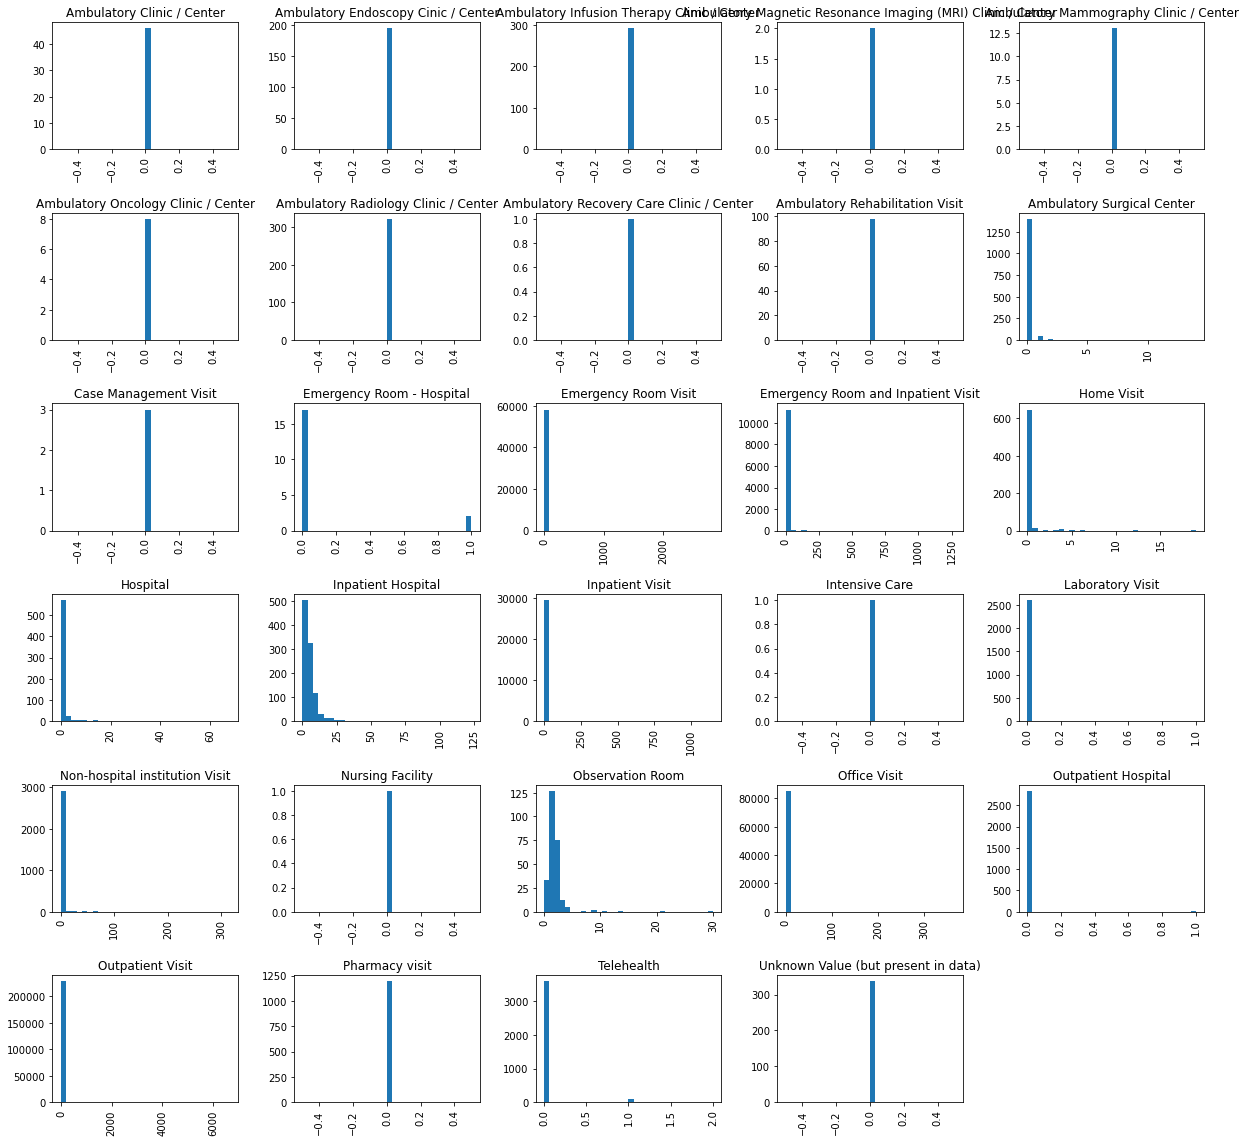

In [25]:
temp2=asthma_visits_df4.groupby(["concept_name_visit"]).size().reset_index(name='counts')
print(temp2)
ax = asthma_visits_df4.hist(column="los",by="concept_name_visit",bins=32,figsize=(20, 20))

No. You cannot have an outpatient visit of 32 days. So, it is either one day (the mistake is in the service end date), or you really have an inpatient visit
https://forums.ohdsi.org/t/visit-occurrence-outpatient-and-long-term-care-visits/2622/2

Observation room is not an outpatient visit. It could be its own thing, or it could be a child of an ER:
https://forums.ohdsi.org/t/observation-room-cms-place-of-service-is-it-inpatient-outpatient-or-er/17847/6

0. Patients extracted : 20369
1. All visits extracted: (101169, 18)
                   concept_name_visit  counts
0           Emergency Room - Hospital      19
1                Emergency Room Visit   58216
2  Emergency Room and Inpatient Visit   11286
3                            Hospital     616
4                  Inpatient Hospital    1024
5                     Inpatient Visit   29749
6                    Observation Room     259


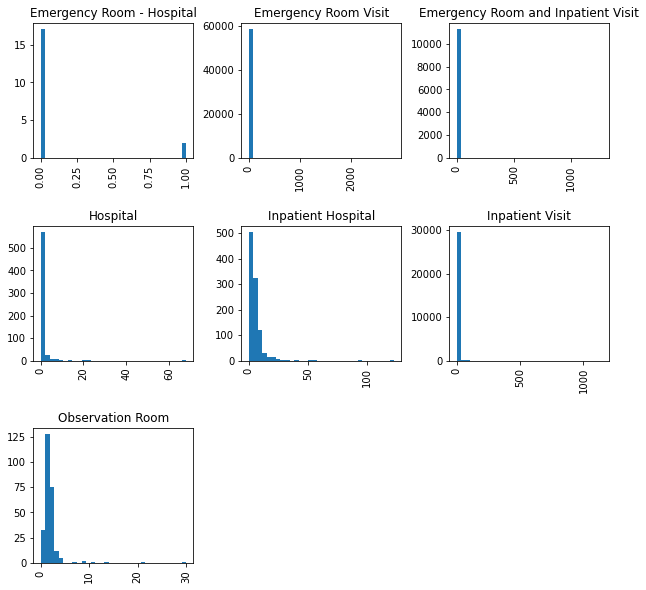

In [26]:
asthma_visits_df5=asthma_visits_df4[asthma_visits_df4['concept_name_visit'].str.contains("Emergency Room|Hospital|Inpatient|Observation Room")]
# exclude any outpatient
asthma_visits_df5=asthma_visits_df5[~asthma_visits_df5['concept_name_visit'].str.contains("Outpatient")]

#sample size
person_ids = asthma_visits_df5['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. All visits extracted: {0}".format(asthma_visits_df5.shape))


# display top 5 rows
temp2=asthma_visits_df5.groupby(["concept_name_visit"]).size().reset_index(name='counts')
print(temp2)
ax = asthma_visits_df5.hist(column="los",by="concept_name_visit",bins=32,figsize=(10, 10))

# Extract Phenotype

In [27]:
person_ids = asthma_visits_df5['person_id'].unique()
print(len(person_ids))
#print(person_ids)
splitted=np.array_split(person_ids,5)

20369


In [28]:
#todo
#empty data frame
asthma_persons_df=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        person.person_id,
        person.birth_datetime as birth_date,
        p_race_concept.concept_name as race,
        p_ethnicity_concept.concept_name as ethnicity,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM  `{0}.person` person 
    LEFT JOIN `{0}.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id
    LEFT JOIN `{0}.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id
    LEFT JOIN `{0}.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN `{0}.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id 
    WHERE person_id IN {1} --only person_ids in df_cohort
    """.format(dataset,tuple(chunk)),dialect = "standard")
    print("Pheno extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    asthma_persons_df=pd.concat([asthma_persons_df, tempDF], ignore_index = True)

print("Persons pheno extracted: {0}".format(asthma_persons_df.shape))
print(asthma_persons_df.head())

Pheno extracted: (4074, 5), chunk:0
Pheno extracted: (4074, 5), chunk:1
Pheno extracted: (4074, 5), chunk:2
Pheno extracted: (4074, 5), chunk:3
Pheno extracted: (4073, 5), chunk:4
Persons pheno extracted: (20369, 5)
   person_id                birth_date                    race  \
0    1101034 1952-06-15 00:00:00+00:00                   White   
1    1390461 1970-06-15 00:00:00+00:00           None of these   
2    1130143 1980-06-15 00:00:00+00:00  I prefer not to answer   
3    3189351 1953-06-15 00:00:00+00:00  I prefer not to answer   
4    2658496 1964-06-15 00:00:00+00:00  I prefer not to answer   

                                           ethnicity sex_at_birth  
0                             Not Hispanic or Latino     Intersex  
1  What Race Ethnicity: Race Ethnicity None Of These     Intersex  
2                          PMI: Prefer Not To Answer         Male  
3                          PMI: Prefer Not To Answer         Male  
4                          PMI: Prefer Not To A

## Race ethnicity collapsing

In [29]:
# Create race/ethnicity
asthma_persons_df['race2']=asthma_persons_df['race']
asthma_persons_df.loc[asthma_persons_df['ethnicity'] == 'Hispanic or Latino', 'race2'] = 'Latino'  
temp2=asthma_persons_df.groupby(["race"])["person_id"].nunique().reset_index(name="countp")
print(temp2)
temp2=asthma_persons_df.groupby(["race2"])["person_id"].nunique().reset_index(name="countp")
temp2

                                        race  countp
0                                      Asian     249
1                  Black or African American    6329
2                     I prefer not to answer     168
3            Middle Eastern or North African      70
4                   More than one population     432
5  Native Hawaiian or Other Pacific Islander      18
6                             None Indicated    3417
7                              None of these     246
8                                  PMI: Skip     431
9                                      White    9009


,race2,countp
0,Asian,234
1,Black or African American,6202
2,I prefer not to answer,168
3,Latino,3847
4,Middle Eastern or North African,64
5,More than one population,373
6,Native Hawaiian or Other Pacific Islander,16
7,None of these,246
8,PMI: Skip,431
9,White,8788


In [30]:
3852/len(person_ids)

0.1891109038244391

## Join phenotype to visits

In [31]:
asthma_visits_df6 = pd.merge(asthma_visits_df5,asthma_persons_df,on='person_id',how='inner')
#sample size
person_ids = asthma_visits_df6['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. Visits+pheno extracted: {0}".format(asthma_visits_df6.shape))
asthma_visits_df6.head(5)

0. Patients extracted : 20369
1. Visits+pheno extracted: (101169, 23)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,...,zip_code,provider_id,income,dep_idx,los,birth_date,race,ethnicity,sex_at_birth,race2
0,2031786,44821988,15000000000741643,15000000000408738,<NA>,None,262,Emergency Room and Inpatient Visit,37.0,2011-06-26,...,606**,<NA>,56305.954102,0.388458,3,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino
1,2031786,44821988,15000000000967727,15000000000467748,<NA>,None,262,Emergency Room and Inpatient Visit,34.7,2009-02-11,...,606**,<NA>,56305.954102,0.388458,5,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino
2,2031786,44821988,15000000000901286,15000000000495402,<NA>,None,9201,Inpatient Visit,41.3,2015-09-23,...,606**,<NA>,56305.954102,0.388458,5,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino
3,2031786,44821988,15000000000533697,15000000000270248,<NA>,None,9203,Emergency Room Visit,36.7,2011-03-08,...,606**,<NA>,56305.954102,0.388458,0,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino
4,2031786,44821988,15000000000678877,15000000000376620,<NA>,None,9203,Emergency Room Visit,38.2,2012-09-09,...,606**,<NA>,56305.954102,0.388458,1,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino


## Remove unknown phenotypes

In [32]:
asthma_visits_df7=asthma_visits_df6[asthma_visits_df6['race2'].str.contains("Asian|White|Black|Latino|Middle Eastern|Native Hawaiian or Other Pacific Islander")]
# display top 5 rows
temp2=asthma_visits_df7.groupby(["race2"])["person_id"].nunique().reset_index(name="countp")
#sample size
person_ids = asthma_visits_df7['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. Visits+pheno extracted: {0}".format(asthma_visits_df7.shape))
temp2

0. Patients extracted : 19151
1. Visits+pheno extracted: (94195, 23)


,race2,countp
0,Asian,234
1,Black or African American,6202
2,Latino,3847
3,Middle Eastern or North African,64
4,Native Hawaiian or Other Pacific Islander,16
5,White,8788


In [33]:
temp4=asthma_visits_df7.groupby(["sex_at_birth"])["person_id"].nunique().reset_index(name="countp")
print(temp4)
asthma_visits_df8=asthma_visits_df7[asthma_visits_df7['sex_at_birth'].str.contains("Female|Male")]
#sample size
person_ids = asthma_visits_df8['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. Visits+pheno extracted: {0}".format(asthma_visits_df8.shape))

# display top 5 rows
temp4=asthma_visits_df8.groupby(["sex_at_birth"])["person_id"].nunique().reset_index(name="countp")
temp4

             sex_at_birth  countp
0                  Female   14056
1  I prefer not to answer      11
2                Intersex       4
3                    Male    4875
4     No matching concept      14
5                    None       5
6               PMI: Skip     186
0. Patients extracted : 18931
1. Visits+pheno extracted: (92814, 23)


,sex_at_birth,countp
0,Female,14056
1,Male,4875


In [34]:
temp3=asthma_visits_df8.groupby(["ethnicity"])["person_id"].nunique().reset_index(name="countp")
print("Patients:")
temp3

Patients:


,ethnicity,countp
0,Hispanic or Latino,3824
1,Not Hispanic or Latino,15107


In [35]:
temp3=asthma_visits_df8.groupby(["ethnicity"]).size().reset_index(name='counts')
print("Visits:")
temp3

Visits:


,ethnicity,counts
0,Hispanic or Latino,19722
1,Not Hispanic or Latino,73092


In [36]:
print("Hispanic patient's proportion : {0}".format(3826/len(person_ids)))
print("Hispanic visits's proportion : {0}".format(19725/asthma_visits_df6.shape[0]))

Hispanic patient's proportion : 0.202102371771169
Hispanic visits's proportion : 0.1949707914479732


# Extract State enrollment

In [37]:
person_ids = asthma_visits_df8['person_id'].unique()
print(len(person_ids))
#print(person_ids)
splitted=np.array_split(person_ids,5)

18931


In [38]:
states_df=pd.DataFrame()
i=0
# COUNT(DISTINCT person_id) AS n_participant
# observation_source_concept_id = 1585249
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT 
        person_id
        ,state_of_residence_source_value AS State
    FROM `{0}.person_ext`
    JOIN `{0}.observation` USING(person_id)
    WHERE observation_source_concept_id = 1585250
    AND (person_id IN {1})""".format(dataset,tuple(chunk)),dialect = "standard")
    print("states extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    states_df=pd.concat([states_df, tempDF], ignore_index = True)

print("Final states extracted: {0}".format(states_df.shape))
states_df['State'] = states_df['State'].str.replace('PII State: ', '')

states_df.head(5)

states extracted: (3787, 2), chunk:0
states extracted: (3786, 2), chunk:1
states extracted: (3786, 2), chunk:2
states extracted: (3786, 2), chunk:3
states extracted: (3786, 2), chunk:4
Final states extracted: (18931, 2)


,person_id,State
0,1783255,MA
1,3305390,MA
2,3166625,MA
3,3311219,MA
4,1771334,MA


In [39]:
temp2=states_df.groupby(["State"])["person_id"].nunique().reset_index(name="countp")
print(temp2)

print("Final observations extracted: {0}".format(temp2.shape))

   State  countp
0     AK       1
1     AL    1244
2     AR       1
3     AZ     665
4     CA    1557
5     CO      23
6     CT      19
7     DE       1
8     FL    1246
9     FM       1
10    GA     326
11    HI       3
12    IA       8
13    ID       3
14    IL    2625
15    IN      42
16    KS      21
17    KY       1
18    LA      35
19    MA    2030
20    MD       6
21    ME      15
22    MH       1
23    MI    1014
24    MN      44
25    MO       9
26    MS      44
27    NC       3
28    NE       3
29    NH      53
30    NJ      49
31    NM      15
32    NV       3
33    NY    2861
34    OH       8
35    OK       3
36    PA    3591
37    PR       3
38    PW       3
39    RI      21
40    SC       3
41    SD       2
42    TN       5
43    TX     267
44    VA       2
45    VI       1
46    VT       9
47    WA      10
48    WI    1025
49    WV       3
50    WY       3
Final observations extracted: (51, 2)


## Join state enrollment to visits

In [41]:
asthma_visits_df9 = pd.merge(asthma_visits_df8,states_df,on='person_id',how='left')
#sample size
person_ids = asthma_visits_df9['person_id'].unique()
print("0. Patients extracted : {0}".format(len(person_ids)))
print("1. Visits+pheno extracted: {0}".format(asthma_visits_df9.shape))
asthma_visits_df9.head(5)

0. Patients extracted : 18931
1. Visits+pheno extracted: (92814, 24)


,person_id,condition_source_concept_id,condition_occurrence_id,visit_occurrence_id,condition_status_concept_id,concept_name_diag,visit_concept_id,concept_name_visit,ageatvisit,visit_start_date,...,provider_id,income,dep_idx,los,birth_date,race,ethnicity,sex_at_birth,race2,State
0,2031786,44821988,15000000000741643,15000000000408738,<NA>,None,262,Emergency Room and Inpatient Visit,37.0,2011-06-26,...,<NA>,56305.954102,0.388458,3,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino,IL
1,2031786,44821988,15000000000967727,15000000000467748,<NA>,None,262,Emergency Room and Inpatient Visit,34.7,2009-02-11,...,<NA>,56305.954102,0.388458,5,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino,IL
2,2031786,44821988,15000000000901286,15000000000495402,<NA>,None,9201,Inpatient Visit,41.3,2015-09-23,...,<NA>,56305.954102,0.388458,5,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino,IL
3,2031786,44821988,15000000000533697,15000000000270248,<NA>,None,9203,Emergency Room Visit,36.7,2011-03-08,...,<NA>,56305.954102,0.388458,0,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino,IL
4,2031786,44821988,15000000000678877,15000000000376620,<NA>,None,9203,Emergency Room Visit,38.2,2012-09-09,...,<NA>,56305.954102,0.388458,1,1974-06-15 00:00:00+00:00,None Indicated,Hispanic or Latino,Male,Latino,IL


# Insurance information

## Using EHR

Extraction of healthcare information, apparently table is empty:

In [42]:
person_ids = asthma_visits_df9['person_id'].unique()
print(len(person_ids))
splitted=np.array_split(person_ids,5)


#empty data frame
hc_df=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        hc.*
    FROM
        `{0}.payer_plan_period` hc 
    WHERE
        hc.person_id IN {1}
""".format(dataset,tuple(chunk)),dialect = "standard")
    print("healthcare extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    hc_df=pd.concat([hc_df, tempDF], ignore_index = True)

print("Final healthcare extracted: {0}".format(hc_df.shape))

hc_df.sort_values(by=['person_id'],ascending=True).head(5)

18931
healthcare extracted: (0, 17), chunk:0
healthcare extracted: (0, 17), chunk:1
healthcare extracted: (0, 17), chunk:2
healthcare extracted: (0, 17), chunk:3
healthcare extracted: (0, 17), chunk:4
Final healthcare extracted: (0, 17)


,payer_plan_period_id,person_id,payer_plan_period_start_date,payer_plan_period_end_date,payer_concept_id,payer_source_value,payer_source_concept_id,plan_concept_id,plan_source_value,plan_source_concept_id,sponsor_concept_id,sponsor_source_value,sponsor_source_concept_id,family_source_value,stop_reason_concept_id,stop_reason_source_value,stop_reason_source_concept_id


## Insurance using survey data

### q1

1585386	Are you covered by health insurance or some other kind of health care plan?

In [70]:
person_ids = asthma_visits_df9['person_id'].unique()
print(len(person_ids))
splitted=np.array_split(person_ids,5)

#empty data frame
hc_df1=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        sv.person_id,
        sv.answer as insur_q1
    FROM
        `{0}.ds_survey` as sv
    WHERE
        sv.person_id IN {1}
        AND sv.question_concept_id = {2} 
""".format(dataset,tuple(chunk),1585386),dialect = "standard")
    print("healthcare extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    hc_df1=pd.concat([hc_df1, tempDF], ignore_index = True)  

print("Final healthcare extracted: {0}".format(hc_df1.shape))
hc_df1.sort_values(by=['person_id'],ascending=True).head(10)

18931
healthcare extracted: (3787, 2), chunk:0
healthcare extracted: (3785, 2), chunk:1
healthcare extracted: (3784, 2), chunk:2
healthcare extracted: (3785, 2), chunk:3
healthcare extracted: (3786, 2), chunk:4
Final healthcare extracted: (18927, 2)


,person_id,insur_q1
4216,1000109,Health Insurance: Yes
7336,1000151,Health Insurance: Yes
17101,1000185,Health Insurance: Yes
8710,1000234,Health Insurance: Yes
6420,1000396,Health Insurance: Yes
10891,1000612,Health Insurance: Yes
13897,1000709,Health Insurance: Yes
15395,1000724,Health Insurance: Yes
6185,1000843,Health Insurance: Yes
283,1000955,PMI: Dont Know


In [60]:
temp2=hc_df1.groupby(["insur_q1"])["person_id"].nunique().reset_index(name="countp")
temp2

,insur_q1,countp
0,Health Insurance: No,700
1,Health Insurance: Yes,17749
2,PMI: Dont Know,129
3,PMI: Prefer Not To Answer,166
4,PMI: Skip,183


### q2 

1585389 What kind of health insurance or health care coverage do you have? Include those that pay for only one type of service (nursing home care, accidents, or dental care). Exclude private plans that only provide extra cash while hospitalized. If you have more than one kind of health insurance, mark all plans that you have

In [69]:
#empty data frame
hc_df2=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        sv.person_id,
        sv.answer as insur_q2
    FROM
        `{0}.ds_survey` as sv
    WHERE
        sv.person_id IN {1}
        AND sv.question_concept_id = {2} 
""".format(dataset,tuple(chunk),1585389),dialect = "standard")
    print("healthcare extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    hc_df2=pd.concat([hc_df2, tempDF], ignore_index = True)  

print("Final healthcare extracted: {0}".format(hc_df2.shape))
hc_df2.sort_values(by=['person_id'],ascending=True).head(10)

healthcare extracted: (3972, 2), chunk:0
healthcare extracted: (3915, 2), chunk:1
healthcare extracted: (3977, 2), chunk:2
healthcare extracted: (3895, 2), chunk:3
healthcare extracted: (3920, 2), chunk:4
Final healthcare extracted: (19679, 2)


,person_id,insur_q2
7271,1000109,PMI: Skip
7843,1000151,PMI: Skip
18943,1000185,PMI: Skip
10248,1000234,PMI: Skip
5792,1000396,PMI: Skip
9194,1000612,PMI: Skip
14001,1000709,PMI: Skip
16072,1000724,Health Insurance Type: State Sponsored
19038,1000724,Health Insurance Type: Medicare
7683,1000843,PMI: Skip


In [63]:
temp2=hc_df2.groupby(["insur_q2"])["person_id"].nunique().reset_index(name="countp")
temp2

,insur_q2,countp
0,Health Insurance Type: Medi GAP,59
1,Health Insurance Type: Medicaid,652
2,Health Insurance Type: Medicare,879
3,Health Insurance Type: Military,29
4,Health Insurance Type: No Coverage,2
5,Health Insurance Type: Other Government,82
6,Health Insurance Type: Private,914
7,Health Insurance Type: Schip,3
8,Health Insurance Type: Single Service,100
9,Health Insurance Type: State Sponsored,159


### q3

43528428	Are you currently covered by any of the following types of health insurance or health coverage plans? Select all that apply from one group.

In [68]:
#empty data frame
hc_df3=pd.DataFrame()
i=0
for chunk in splitted:
    tempDF = pd.read_gbq("""
    SELECT
        sv.person_id,
        sv.answer as insur_q3
    FROM
        `{0}.ds_survey` as sv
    WHERE
        sv.person_id IN {1}
        AND sv.question_concept_id = {2} 
""".format(dataset,tuple(chunk),43528428),dialect = "standard")
    print("healthcare extracted: {0}, chunk:{1}".format(tempDF.shape,i))
    i=i+1
    #adding the chunk
    hc_df3=pd.concat([hc_df3, tempDF], ignore_index = True)  

print("Final healthcare extracted: {0}".format(hc_df3.shape))
hc_df3.sort_values(by=['person_id'],ascending=True).head(10)

healthcare extracted: (3962, 2), chunk:0
healthcare extracted: (4062, 2), chunk:1
healthcare extracted: (3673, 2), chunk:2
healthcare extracted: (3911, 2), chunk:3
healthcare extracted: (3915, 2), chunk:4
Final healthcare extracted: (19523, 2)


,person_id,insur_q3
6035,1000109,Insurance Type Update: Medicaid
6944,1000151,Insurance Type Update: Military
5932,1000151,Insurance Type Update: VA
18976,1000185,Insurance Type Update: Medicare
19002,1000185,Insurance Type Update: Employer Or Union
8662,1000234,Insurance Type Update: Medicare
6888,1000396,Insurance Type Update: Medicare
7354,1000396,Insurance Type Update: VA
9151,1000612,Insurance Type Update: Medicaid
15444,1000709,Insurance Type Update: Employer Or Union


In [65]:
temp2=hc_df3.groupby(["insur_q3"])["person_id"].nunique().reset_index(name="countp")
temp2

,insur_q3,countp
0,Insurance Type Update: Employer Or Union,4670
1,Insurance Type Update: Indian,16
2,Insurance Type Update: Medicaid,6969
3,Insurance Type Update: Medicare,5193
4,Insurance Type Update: Military,206
5,Insurance Type Update: None,98
6,Insurance Type Update: Other Health Plan,555
7,Insurance Type Update: Purchased,1209
8,Insurance Type Update: VA,357
9,Invalid,69


In [71]:
hc_df = pd.merge(hc_df2,hc_df3,on='person_id',how='left')
hc_df = pd.merge(hc_df,hc_df1,on='person_id',how='left')
#sample size
person_ids = hc_df['person_id'].unique()
print("0. Insurance extracted : {0}".format(hc_df.shape))
hc_df.head(5)

0. Insurance extracted : (23219, 4)


,person_id,insur_q2,insur_q3,insur_q1
0,2592282,PMI: Skip,Insurance Type Update: Medicare,Health Insurance: Yes
1,1231991,PMI: Skip,Insurance Type Update: Medicaid,Health Insurance: Yes
2,1284243,PMI: Skip,Insurance Type Update: Medicaid,Health Insurance: Yes
3,1745519,PMI: Skip,Insurance Type Update: Medicare,Health Insurance: Yes
4,2679854,PMI: Skip,Insurance Type Update: Medicaid,Health Insurance: Yes


# Extract Comorbidities

In [40]:
person_ids = asthma_visits_df9['person_id'].unique()
print(len(person_ids))
#print(person_ids)
splitted=np.array_split(person_ids,5)

18932


## Comorbidities Concepts

1. G47.3 Sleep apnea
2. E66.0, E66.2, E66.3, E66.8, E66.9 Obesity
3. J30.x Allergic rhinitis
4. K20.0 EoE
5. K21.x Gastro-esophageal reflux disease
6. L20.x AD
7. Z91.01 Z91.02  Food/Food additives allergy status
8. E11.x Type 2 Diabetes
9. I10.x Hypertension
10. I25.x CIHD
11. J44.x COPD
12. F32.x and F33.x Depression
13. C00x-D49 Neoplasm (Cancer)
14. N18.x Chronic Kidney Disease (CKD)

```
    # Sleep apnea
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^G47.3)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^327.2'))
    #Obesity
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^E66.0)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^278.0'))
    #AR
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^J30)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^477'))
    #EoE
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^K20.0)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^530.13'))
    
    #GERD
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^K21)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^530.81'))
    # AD
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^L20)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^691'))
    
    #FA
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^Z91.01|^Z91.02|^L50.0)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(693.1|695.6|695.7|^708.0|^V15.0[1-5])'))
    
    # Diabetes TI TII
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^E10|^E11)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^250'))
    
    #HTA
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^I10)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^401'))
   
    #CHD
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^I20|^I21|^I22|^I23|^I24|^I25'))   
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'410|411|412|413|414'))   
    #COPD
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^J44'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'491.2|493.2|496'))
    # Depression
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^F32|^F33|^F41|^F43'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'296.2|296.3|300.0|300.8'))
    #Cancer
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^C+|^D[0-4]+)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(1[4-9][0-9]|2[0-3][0-9])'))

    #CKD
    OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^N18'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^585'))
```

## AD

In [41]:
# coding for AD comorbidities
ad_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^L20)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^691'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
ad_concepts_tuple = tuple(ad_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
# print(len(comor_concepts_tuple))
# print(comor_concepts_tuple)
ad_concepts_tuple = tuple(ad_concepts_df['concept_id'])
# print(len(comor_concepts_tuple))
ad_concepts_df.sort_values(by=['concept_code'],ascending=True).head(50)

,concept_name,concept_code,concept_id
5,Atopic dermatitis and related conditions,691,44836148
3,Diaper or napkin rash,691.0,44822164
8,Other atopic dermatitis and related conditions,691.8,44824472
9,Atopic dermatitis,L20,1569765
2,Besnier's prurigo,L20.0,35208449
4,Other atopic dermatitis,L20.8,1569766
1,Atopic neurodermatitis,L20.81,45543364
11,Flexural eczema,L20.82,45552974
6,Infantile (acute) (chronic) eczema,L20.83,45572263
7,Intrinsic (allergic) eczema,L20.84,45601213


In [42]:
ad_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,ad_concepts_tuple,tuple(person_ids)),dialect = "standard")

ad_visits_df["icd_group"]="AD"
print("1. AD Comorbidities' visits extracted: {0}".format(ad_visits_df.shape))
print(ad_visits_df['visit_start_date'].isna().sum())
ad_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. AD Comorbidities' valid visits extracted: {0}".format(ad_visits_df.shape))
print(ad_visits_df['visit_start_date'].isna().sum())

1. AD Comorbidities' visits extracted: (7253, 7)
483
2. AD Comorbidities' valid visits extracted: (6770, 7)
0


In [43]:
ad_visits_df=ad_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. AD First comorbidities' visits extracted: {0}".format(ad_visits_df.shape))
ad_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. AD First comorbidities' visits extracted: (1093, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1003579,44824472,Primary diagnosis,Outpatient Visit,12.0,2000-06-27,AD
1,1003851,44824472,No matching concept,Outpatient Visit,55.1,2007-07-13,AD
2,1006564,44824472,Final diagnosis (discharge),Outpatient Visit,40.6,2004-01-07,AD
3,1008222,44824472,Secondary diagnosis,Outpatient Visit,19.8,2012-03-16,AD
4,1008790,44824472,Final diagnosis (discharge),Office Visit,54.1,2015-07-28,AD


## AR

```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^J30)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^477'))
```

In [44]:
# coding for AR comorbidities
ar_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^J30)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^477'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
ar_concepts_tuple = tuple(ar_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
# print(len(comor_concepts_tuple))
# print(comor_concepts_tuple)
ar_concepts_tuple = tuple(ar_concepts_df['concept_id'])
# print(len(comor_concepts_tuple))
ar_concepts_df.sort_values(by=['concept_code'],ascending=True).head(20)

,concept_name,concept_code,concept_id
6,Allergic rhinitis,477,44821978
0,Allergic rhinitis due to pollen,477.0,44831272
14,Allergic rhinitis due to food,477.1,44837129
8,Allergic rhinitis due to animal (cat) (dog) ha...,477.2,44826666
7,Allergic rhinitis due to other allergen,477.8,44821979
13,"Allergic rhinitis, cause unspecified",477.9,44835974
1,Vasomotor and allergic rhinitis,J30,1569472
2,Vasomotor rhinitis,J30.0,35207971
11,Allergic rhinitis due to pollen,J30.1,35207972
10,Other seasonal allergic rhinitis,J30.2,35207973


In [45]:
ar_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,ar_concepts_tuple,tuple(person_ids)),dialect = "standard")

ar_visits_df["icd_group"]="AR"
print("1. AR Comorbidities' visits extracted: {0}".format(ar_visits_df.shape))
print(ar_visits_df['visit_start_date'].isna().sum())
ar_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. AR Comorbidities' valid visits extracted: {0}".format(ar_visits_df.shape))
print(ar_visits_df['visit_start_date'].isna().sum())
ar_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. AR Comorbidities' visits extracted: (115491, 7)
14400
2. AR Comorbidities' valid visits extracted: (101091, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
96203,1000151,44835974,No matching concept,Outpatient Visit,40.2,2004-09-13,AR
35574,1000724,45581853,Final diagnosis (discharge),Office Visit,18.7,2018-02-27,AR
56730,1000724,35207973,Final diagnosis (discharge),Office Visit,18.7,2018-02-27,AR
35530,1000724,45581853,Final diagnosis (discharge),Office Visit,18.8,2018-04-06,AR
56642,1000724,35207973,Final diagnosis (discharge),Office Visit,18.8,2018-04-06,AR


In [46]:
ar_visits_df=ar_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence AR comorbidities' visits extracted: {0}".format(ar_visits_df.shape))
ar_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence AR comorbidities' visits extracted: (7152, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000151,44835974,No matching concept,Outpatient Visit,40.2,2004-09-13,AR
1,1000724,45581853,Final diagnosis (discharge),Office Visit,18.7,2018-02-27,AR
2,1000843,44835974,Secondary diagnosis,Outpatient Visit,41.4,2004-11-01,AR
3,1001704,45581853,Suggested billing diagnosis,Office Visit,44.9,2018-04-26,AR
4,1003045,44835974,None,Outpatient Visit,56.8,2004-03-29,AR


## Cancer
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^C+|^D[0-4]+)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(1[4-9][0-9]|2[0-3][0-9])'))
```

In [47]:
# coding for cancer comorbidities
cancer_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^C+|^D[0-4]+)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(1[4-9][0-9]|2[0-3][0-9])'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
cancer_concepts_tuple = tuple(cancer_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(cancer_concepts_tuple))
# print(cancer_concepts_tuple)
cancer_concepts_tuple = tuple(cancer_concepts_df['concept_id'])
# print(len(cancer_concepts_tuple))
cancer_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

2611


,concept_name,concept_code,concept_id
2563,Malignant neoplasm of lip,140,44824020
856,"Malignant neoplasm of upper lip, vermilion border",140.0,44829787
2465,"Malignant neoplasm of lower lip, vermilion border",140.1,44828724
926,"Malignant neoplasm of upper lip, inner aspect",140.3,44825188
2476,"Malignant neoplasm of lower lip, inner aspect",140.4,44836817


In [48]:
cancer_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,cancer_concepts_tuple,tuple(person_ids)),dialect = "standard")

cancer_visits_df["icd_group"]="Cancer"
print("1. Cancer Comorbidities' visits extracted: {0}".format(cancer_visits_df.shape))
print(cancer_visits_df['visit_start_date'].isna().sum())
cancer_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. Cancer Comorbidities' valid visits extracted: {0}".format(cancer_visits_df.shape))
print(cancer_visits_df['visit_start_date'].isna().sum())
cancer_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. Cancer Comorbidities' visits extracted: (533172, 7)
26440
2. Cancer Comorbidities' valid visits extracted: (506732, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
438100,1000185,35206565,Final diagnosis (discharge),Outpatient Visit,72.9,2018-05-21,Cancer
289552,1000185,45537897,Final diagnosis (discharge),Outpatient Visit,73.9,2019-04-23,Cancer
291007,1000185,35206514,Final diagnosis (discharge),Outpatient Visit,74.1,2019-08-05,Cancer
291039,1000185,35206511,Final diagnosis (discharge),Outpatient Visit,74.1,2019-08-05,Cancer
438139,1000185,35206565,Final diagnosis (discharge),Outpatient Visit,76.2,2021-08-24,Cancer


In [49]:
cancer_visits_df=cancer_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence cancer comorbidities' visits extracted: {0}".format(cancer_visits_df.shape))
cancer_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence cancer comorbidities' visits extracted: (10972, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000185,35206565,Final diagnosis (discharge),Outpatient Visit,72.9,2018-05-21,Cancer
1,1000234,45557062,Final diagnosis (discharge),Office Visit,88.8,2016-04-06,Cancer
2,1000396,44821770,No matching concept,Outpatient Visit,57.2,2005-08-26,Cancer
3,1001131,44819492,Primary diagnosis,Outpatient Visit,43.7,2011-03-07,Cancer
4,1001290,44834528,None,Outpatient Visit,36.7,1996-02-26,Cancer


## CHD
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^I20|^I21|^I22|^I23|^I24|^I25'))   
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'410|411|412|413|414')) 
```

In [50]:
# coding for chd comorbidities
chd_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^I20|^I21|^I22|^I23|^I24|^I25'))   
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'410|411|412|413|414')) 
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
chd_concepts_tuple = tuple(chd_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(chd_concepts_tuple))
# print(comor_concepts_tuple)
chd_concepts_tuple = tuple(chd_concepts_df['concept_id'])
# print(len(comor_concepts_tuple))
chd_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

154


,concept_name,concept_code,concept_id
56,Acute myocardial infarction,410,44832372
94,"Acute myocardial infarction, of anterolateral ...",410.0,44820857
46,Acute myocardial infarction of anterolateral w...,410.00,44824237
82,Acute myocardial infarction of anterolateral w...,410.01,44823111
117,Acute myocardial infarction of anterolateral w...,410.02,44820858


In [51]:
chd_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,chd_concepts_tuple,tuple(person_ids)),dialect = "standard")

chd_visits_df["icd_group"]="CHD"
print("1. CHD Comorbidities' visits extracted: {0}".format(chd_visits_df.shape))
print(chd_visits_df['visit_start_date'].isna().sum())
chd_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. CHD Comorbidities' valid visits extracted: {0}".format(chd_visits_df.shape))
print(chd_visits_df['visit_start_date'].isna().sum())
chd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. CHD Comorbidities' visits extracted: (169257, 7)
12696
2. CHD Comorbidities' valid visits extracted: (156561, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
75986,1000109,44830080,Primary diagnosis,Outpatient Visit,38.0,2005-06-29,CHD
108126,1000109,45586572,Primary diagnosis,Office Visit,53.6,2021-01-04,CHD
108127,1000109,45586572,Primary diagnosis,Office Visit,53.6,2021-01-04,CHD
84002,1000234,44830080,Final diagnosis (discharge),Outpatient Visit,80.0,2007-06-18,CHD
83031,1000234,44830080,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,CHD


In [52]:
chd_visits_df=chd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence CHD comorbidities' visits extracted: {0}".format(chd_visits_df.shape))
chd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence CHD comorbidities' visits extracted: (5862, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000109,44830080,Primary diagnosis,Outpatient Visit,38.0,2005-06-29,CHD
1,1000234,44830080,Final diagnosis (discharge),Outpatient Visit,80.0,2007-06-18,CHD
2,1000612,44830080,None,Emergency Room Visit,45.2,2014-08-22,CHD
3,1000843,35207702,Discharge diagnosis,Emergency Room Visit,56.8,2020-03-27,CHD
4,1001131,45586572,Secondary diagnosis,Emergency Room and Inpatient Visit,49.3,2016-09-15,CHD


## CKD
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^N18'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^585'))
```

In [53]:
# coding for ckd comorbidities
ckd_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^N18'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^585'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
ckd_concepts_tuple = tuple(ckd_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(ckd_concepts_tuple))
# print(ckd_concepts_tuple)
ckd_concepts_tuple = tuple(ckd_concepts_df['concept_id'])
# print(len(ckd_concepts_tuple))
ckd_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

19


,concept_name,concept_code,concept_id
4,Chronic kidney disease (CKD),585,44830172
10,"Chronic kidney disease, Stage I",585.1,44837191
1,"Chronic kidney disease, Stage II (mild)",585.2,44830173
15,"Chronic kidney disease, Stage III (moderate)",585.3,44827888
16,"Chronic kidney disease, Stage IV (severe)",585.4,44820970


In [54]:
ckd_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,ckd_concepts_tuple,tuple(person_ids)),dialect = "standard")

ckd_visits_df["icd_group"]="CKD"
print("1. CKD Comorbidities' visits extracted: {0}".format(ckd_visits_df.shape))
print(ckd_visits_df['visit_start_date'].isna().sum())
ckd_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. CKD Comorbidities' valid visits extracted: {0}".format(ckd_visits_df.shape))
print(ckd_visits_df['visit_start_date'].isna().sum())
ckd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. CKD Comorbidities' visits extracted: (142160, 7)
11223
2. CKD Comorbidities' valid visits extracted: (130937, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
19082,1000612,35209276,None,Emergency Room and Inpatient Visit,49.3,2018-10-11,CKD
17471,1000612,35209276,None,Emergency Room and Inpatient Visit,49.5,2018-12-16,CKD
2002,1000612,35209275,None,Outpatient Visit,49.6,2019-01-17,CKD
5191,1000612,35209275,None,Outpatient Visit,49.6,2019-01-17,CKD
1980,1000612,35209275,None,Emergency Room and Inpatient Visit,49.7,2019-03-09,CKD


In [55]:
ckd_visits_df=ckd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence CKD comorbidities' visits extracted: {0}".format(ckd_visits_df.shape))
ckd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence CKD comorbidities' visits extracted: (3171, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000612,35209276,None,Emergency Room and Inpatient Visit,49.3,2018-10-11,CKD
1,1003194,35209276,No matching concept,Inpatient Visit,73.9,2018-05-22,CKD
2,1003972,35209276,No matching concept,Inpatient Visit,60.3,2019-10-16,CKD
3,1004308,44836035,None,Outpatient Visit,57.2,2015-08-31,CKD
4,1005022,35209276,None,Outpatient Visit,61.6,2020-01-23,CKD


## COPD
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^J44'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'491.2|493.2|496'))
```

In [56]:
# coding for copd comorbidities
copd_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^J44'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'491.2|493.2|496'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
copd_concepts_tuple = tuple(copd_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(copd_concepts_tuple))
# print(ccopd_concepts_tuple)
copd_concepts_tuple = tuple(copd_concepts_df['concept_id'])
# print(len(copd_concepts_tuple))
copd_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

13


,concept_name,concept_code,concept_id
6,Obstructive chronic bronchitis,491.2,44829010
7,Obstructive chronic bronchitis without exacerb...,491.20,44832422
8,Obstructive chronic bronchitis with (acute) ex...,491.21,44821986
10,Obstructive chronic bronchitis with acute bron...,491.22,44825474
12,Chronic obstructive asthma,493.2,44829012


In [57]:
copd_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date,
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,copd_concepts_tuple,tuple(person_ids)),dialect = "standard")

copd_visits_df["icd_group"]="COPD"
print("1. COPD Comorbidities' visits extracted: {0}".format(copd_visits_df.shape))
print(copd_visits_df['visit_start_date'].isna().sum())
copd_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. COPD Comorbidities' valid visits extracted: {0}".format(copd_visits_df.shape))
print(copd_visits_df['visit_start_date'].isna().sum())
copd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. COPD Comorbidities' visits extracted: (122995, 7)
10275
2. COPD Comorbidities' valid visits extracted: (112720, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
11429,1000234,44831280,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,COPD
11430,1000234,44831280,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,COPD
86218,1000843,35208025,Secondary diagnosis,Emergency Room Visit,54.5,2017-12-21,COPD
79924,1000843,35208025,Discharge diagnosis,Emergency Room Visit,56.8,2020-03-27,COPD
79986,1000843,35208025,Discharge diagnosis,Emergency Room Visit,57.0,2020-05-29,COPD


In [58]:
copd_visits_df=copd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence COPD comorbidities' visits extracted: {0}".format(copd_visits_df.shape))
copd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence COPD comorbidities' visits extracted: (5219, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000234,44831280,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,COPD
1,1000843,35208025,Secondary diagnosis,Emergency Room Visit,54.5,2017-12-21,COPD
2,1000955,44837136,None,Emergency Room Visit,28.9,2008-04-22,COPD
3,1002767,44837136,Final diagnosis (discharge),Emergency Room and Inpatient Visit,56.9,2015-04-22,COPD
4,1003851,44829013,No matching concept,Outpatient Visit,47.7,2000-03-15,COPD


## Depression
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^F32|^F33|^F41|^F43'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'296.2|296.3|300.0|300.8'))
```

In [59]:
# coding for depression comorbidities
depre_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^F32|^F33|^F41|^F43'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'296.2|296.3|300.0|300.8'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
depre_concepts_tuple = tuple(depre_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(depre_concepts_tuple))
# print(depre_concepts_tuple)
depre_concepts_tuple = tuple(depre_concepts_df['concept_id'])
# print(len(depre_concepts_tuple))
depre_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

68


,concept_name,concept_code,concept_id
41,"Major depressive disorder, single episode",296.2,44821821
42,"Major depressive affective disorder, single ep...",296.20,44822975
38,"Major depressive affective disorder, single ep...",296.21,44824114
8,"Major depressive affective disorder, single ep...",296.22,44827654
27,"Major depressive affective disorder, single ep...",296.23,44835784


In [60]:
depre_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,depre_concepts_tuple,tuple(person_ids)),dialect = "standard")

depre_visits_df["icd_group"]="Depression"
print("1. Depression Comorbidities' visits extracted: {0}".format(depre_visits_df.shape))
print(depre_visits_df['visit_start_date'].isna().sum())
depre_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. Depression Comorbidities' valid visits extracted: {0}".format(depre_visits_df.shape))
print(depre_visits_df['visit_start_date'].isna().sum())
depre_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. Depression Comorbidities' visits extracted: (540522, 7)
54506
2. Depression Comorbidities' valid visits extracted: (486016, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
250998,1000109,766349,Primary diagnosis,Telehealth,53.0,2020-06-30,Depression
421150,1000109,35207155,Primary diagnosis,Telehealth,53.0,2020-06-30,Depression
11292,1000109,35207150,Primary diagnosis,Telehealth,53.0,2020-07-01,Depression
11293,1000109,35207150,Primary diagnosis,Telehealth,53.0,2020-07-01,Depression
250915,1000109,766349,Primary diagnosis,Telehealth,53.0,2020-07-01,Depression


In [61]:
depre_visits_df=depre_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence depression comorbidities' visits extracted: {0}".format(depre_visits_df.shape))
depre_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence depression comorbidities' visits extracted: (11876, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000109,766349,Primary diagnosis,Telehealth,53.0,2020-06-30,Depression
1,1000151,44831093,No matching concept,Outpatient Visit,40.3,2004-10-04,Depression
2,1000185,35207173,Final diagnosis (discharge),Outpatient Visit,71.5,2016-12-01,Depression
3,1000396,44832239,No matching concept,Outpatient Visit,52.3,2000-10-02,Depression
4,1000612,44832239,None,Emergency Room and Inpatient Visit,43.2,2012-08-24,Depression


## Diabetes
```
(vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^E10|^E11)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^250'))
```

In [62]:
# coding for diab comorbidities
diab_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^E10|^E11)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^250'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
diab_concepts_tuple = tuple(diab_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(diab_concepts_tuple))
# print(diab_concepts_tuple)
diab_concepts_tuple = tuple(diab_concepts_df['concept_id'])
# print(len(diab_concepts_tuple))
diab_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

244


,concept_name,concept_code,concept_id
106,Diabetes mellitus,250,44833365
107,Diabetes mellitus without mention of complication,250.0,44834548
48,Diabetes mellitus without mention of complicat...,250.00,44836914
101,Diabetes mellitus without mention of complicat...,250.01,44820682
50,Diabetes mellitus without mention of complicat...,250.02,44836915


In [63]:
diab_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,diab_concepts_tuple,tuple(person_ids)),dialect = "standard")

diab_visits_df["icd_group"]="Diabetes"
print("1. Diabetes Comorbidities' visits extracted: {0}".format(diab_visits_df.shape))
print(diab_visits_df['visit_start_date'].isna().sum())
diab_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. Diabetes Comorbidities' valid visits extracted: {0}".format(diab_visits_df.shape))
print(diab_visits_df['visit_start_date'].isna().sum())
diab_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. Diabetes Comorbidities' visits extracted: (621699, 7)
46757
2. Diabetes Comorbidities' valid visits extracted: (574942, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
274887,1000234,44836914,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,Diabetes
274888,1000234,44836914,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,Diabetes
270745,1000396,44836914,No matching concept,Outpatient Visit,64.9,2013-04-30,Diabetes
266159,1000396,44836914,No matching concept,Outpatient Visit,64.9,2013-05-22,Diabetes
267944,1000396,44836914,No matching concept,Outpatient Visit,65.0,2013-06-26,Diabetes


In [64]:
diab_visits_df=diab_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#column_headers = list(diab_visits_df.columns.values)
#print("The Column Header before:", column_headers)
#sample size
print("3. Incidence diab comorbidities' visits extracted: {0}".format(diab_visits_df.shape))
diab_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)
#column_headers = list(diab_visits_df.columns.values)
#print("The Column Header after:", column_headers)

3. Incidence diab comorbidities' visits extracted: (6787, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000234,44836914,Final diagnosis (discharge),Inpatient Visit,80.3,2007-09-25,Diabetes
1,1000396,44836914,No matching concept,Outpatient Visit,64.9,2013-04-30,Diabetes
2,1001290,44836914,None,Outpatient Visit,42.9,2002-05-07,Diabetes
3,1001937,44836914,No matching concept,Emergency Room Visit,43.8,2014-04-01,Diabetes
4,1003262,44836914,Primary diagnosis,Outpatient Visit,58.6,2011-02-07,Diabetes


## EoE
```
(vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^K20.0)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^530.13'))
```

In [65]:
# coding for EoE comorbidities
eoe_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^K20.0)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^530.13'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
eoe_concepts_tuple = tuple(eoe_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(eoe_concepts_tuple))
# print(eoe_concepts_tuple)
eoe_concepts_tuple = tuple(eoe_concepts_df['concept_id'])
# print(len(eoe_concepts_tuple))
eoe_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

2


,concept_name,concept_code,concept_id
0,Eosinophilic esophagitis,530.13,44820925
1,Eosinophilic esophagitis,K20.0,45538508


In [66]:
eoe_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,eoe_concepts_tuple,tuple(person_ids)),dialect = "standard")

eoe_visits_df["icd_group"]="EoE"
print("1. EoE Comorbidities' visits extracted: {0}".format(eoe_visits_df.shape))
print(eoe_visits_df['visit_start_date'].isna().sum())
eoe_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. EoE Comorbidities' valid visits extracted: {0}".format(eoe_visits_df.shape))
print(eoe_visits_df['visit_start_date'].isna().sum())
eoe_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. EoE Comorbidities' visits extracted: (2077, 7)
105
2. EoE Comorbidities' valid visits extracted: (1972, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
1087,1049908,45538508,None,Outpatient Visit,37.9,2021-04-29,EoE
2045,1049908,45538508,None,Outpatient Visit,37.9,2021-04-29,EoE
895,1049908,45538508,None,Outpatient Visit,37.9,2021-05-27,EoE
905,1049908,45538508,None,Outpatient Visit,37.9,2021-05-27,EoE
1459,1049908,45538508,None,Outpatient Visit,37.9,2021-05-27,EoE


In [67]:
eoe_visits_df=eoe_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence EoE comorbidities' visits extracted: {0}".format(eoe_visits_df.shape))
eoe_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence EoE comorbidities' visits extracted: (128, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1049908,45538508,None,Outpatient Visit,37.9,2021-04-29,EoE
1,1052904,44820925,No matching concept,Office Visit,44.4,2012-10-23,EoE
2,1060221,45538508,None,Outpatient Visit,75.2,2021-08-25,EoE
3,1064420,44820925,No matching concept,Office Visit,53.0,2015-06-17,EoE
4,1072165,45538508,No matching concept,Outpatient Visit,49.2,2016-08-29,EoE


## FA
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^Z91.01|^Z91.02|^L50.0)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(693.1|695.6|695.7|^708.0|^V15.0[1-5])'))
```

In [68]:
# coding for fa comorbidities
fa_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^Z91.01|^Z91.02|^L50.0)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(693.1|695.6|695.7|^708.0|^V15.0[1-5])'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
fa_concepts_tuple = tuple(fa_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(fa_concepts_tuple))
# print(fa_concepts_tuple)
fa_concepts_tuple = tuple(fa_concepts_df['concept_id'])
# print(len(fa_concepts_tuple))
fa_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

3


,concept_name,concept_code,concept_id
0,Dermatitis due to food taken internally,693.1,44830300
1,Allergic urticaria,708.0,44828018
2,Allergic urticaria,L50.0,35208535


In [69]:
fa_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,fa_concepts_tuple,tuple(person_ids)),dialect = "standard")

fa_visits_df["icd_group"]="FA"
print("1. FA Comorbidities' visits extracted: {0}".format(fa_visits_df.shape))
print(fa_visits_df['visit_start_date'].isna().sum())
fa_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. FA Comorbidities' valid visits extracted: {0}".format(fa_visits_df.shape))
print(fa_visits_df['visit_start_date'].isna().sum())
fa_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. FA Comorbidities' visits extracted: (1029, 7)
94
2. FA Comorbidities' valid visits extracted: (935, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
487,1002767,35208535,Final diagnosis (discharge),Emergency Room Visit,58.0,2016-05-28,FA
791,1004930,44828018,No matching concept,Outpatient Visit,47.9,2009-05-04,FA
872,1004930,44828018,No matching concept,Outpatient Visit,48.0,2009-06-04,FA
843,1004930,44828018,No matching concept,Outpatient Visit,48.0,2009-06-19,FA
799,1004930,44828018,No matching concept,Outpatient Visit,48.1,2009-08-05,FA


In [70]:
fa_visits_df=fa_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence FA comorbidities' visits extracted: {0}".format(fa_visits_df.shape))
fa_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence FA comorbidities' visits extracted: (441, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1002767,35208535,Final diagnosis (discharge),Emergency Room Visit,58.0,2016-05-28,FA
1,1004930,44828018,No matching concept,Outpatient Visit,47.9,2009-05-04,FA
2,1006406,35208535,No matching concept,Outpatient Visit,61.7,2018-02-26,FA
3,1008222,44830300,Primary diagnosis,Outpatient Visit,16.5,2008-12-10,FA
4,1012680,35208535,None,Outpatient Visit,26.4,2015-11-13,FA


## GERD
```
(vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^K21)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^530.81'))
```

In [71]:
# coding for gerd comorbidities
gerd_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^K21)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^530.81'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
gerd_concepts_tuple = tuple(gerd_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(gerd_concepts_tuple))
# print(gerd_concepts_tuple)
gerd_concepts_tuple = tuple(gerd_concepts_df['concept_id'])
# print(len(gerd_concepts_tuple))
gerd_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

6


,concept_name,concept_code,concept_id
4,Esophageal reflux,530.81,44822019
3,Gastro-esophageal reflux disease,K21,1569558
5,Gastro-esophageal reflux disease with esophagitis,K21.0,35208189
2,Gastro-esophageal reflux disease with esophagi...,K21.00,725363
1,Gastro-esophageal reflux disease with esophagi...,K21.01,725364


In [72]:
gerd_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,gerd_concepts_tuple,tuple(person_ids)),dialect = "standard")

gerd_visits_df["icd_group"]="GERD"
print("1. GERD Comorbidities' visits extracted: {0}".format(gerd_visits_df.shape))
print(gerd_visits_df['visit_start_date'].isna().sum())
gerd_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. GERD Comorbidities' valid visits extracted: {0}".format(gerd_visits_df.shape))
print(gerd_visits_df['visit_start_date'].isna().sum())
gerd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. GERD Comorbidities' visits extracted: (201934, 7)
15212
2. GERD Comorbidities' valid visits extracted: (186722, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
17821,1000109,35208190,Primary diagnosis,Office Visit,54.6,2022-02-01,GERD
17826,1000109,35208190,Primary diagnosis,Office Visit,54.6,2022-02-01,GERD
181605,1000151,44822019,No matching concept,Outpatient Visit,51.1,2015-07-22,GERD
184791,1000151,35208189,No matching concept,Outpatient Visit,52.3,2016-10-09,GERD
191276,1000151,35208190,No matching concept,Outpatient Visit,54.6,2019-01-22,GERD


In [73]:
gerd_visits_df=gerd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence GERD comorbidities' visits extracted: {0}".format(gerd_visits_df.shape))
gerd_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence GERD comorbidities' visits extracted: (10924, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000109,35208190,Primary diagnosis,Office Visit,54.6,2022-02-01,GERD
1,1000151,44822019,No matching concept,Outpatient Visit,51.1,2015-07-22,GERD
2,1000612,44822019,None,Outpatient Visit,46.3,2015-09-15,GERD
3,1000724,35208190,Final diagnosis (discharge),Outpatient Visit,18.3,2017-09-29,GERD
4,1001131,44822019,Secondary diagnosis,Outpatient Visit,43.6,2011-01-06,GERD


## HTA
```
(vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^I10)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^401'))
```

In [74]:
# coding for obesity comorbidities
hta_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^I10)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^401'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
hta_concepts_tuple = tuple(hta_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(hta_concepts_tuple))
# print(hta_concepts_tuple)
hta_concepts_tuple = tuple(hta_concepts_df['concept_id'])
# print(len(hta_concepts_tuple))
hta_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

5


,concept_name,concept_code,concept_id
2,Essential hypertension,401,44833556
1,Malignant essential hypertension,401.0,44823109
4,Benign essential hypertension,401.1,44834715
3,Unspecified essential hypertension,401.9,44821949
0,Essential (primary) hypertension,I10,35207668


In [75]:
hta_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,hta_concepts_tuple,tuple(person_ids)),dialect = "standard")

hta_visits_df["icd_group"]="HTA"
print("1. HTA Comorbidities' visits extracted: {0}".format(hta_visits_df.shape))
print(hta_visits_df['visit_start_date'].isna().sum())
hta_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. HTA Comorbidities' valid visits extracted: {0}".format(hta_visits_df.shape))
print(hta_visits_df['visit_start_date'].isna().sum())
hta_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. HTA Comorbidities' visits extracted: (513468, 7)
37079
2. HTA Comorbidities' valid visits extracted: (476389, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
193450,1000109,44821949,Secondary diagnosis,Emergency Room Visit,43.0,2010-06-25,HTA
195036,1000109,35207668,Secondary diagnosis,Emergency Room Visit,52.0,2019-06-17,HTA
154563,1000109,35207668,Primary diagnosis,Outpatient Visit,52.0,2019-06-20,HTA
12194,1000109,35207668,None,Outpatient Visit,52.1,2019-08-01,HTA
46378,1000109,35207668,None,Outpatient Visit,52.1,2019-08-01,HTA


In [76]:
hta_visits_df=hta_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence HTA comorbidities' visits extracted: {0}".format(hta_visits_df.shape))
hta_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence HTA comorbidities' visits extracted: (12142, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000109,44821949,Secondary diagnosis,Emergency Room Visit,43.0,2010-06-25,HTA
1,1000151,44821949,No matching concept,Outpatient Visit,39.7,2004-03-06,HTA
2,1000396,44821949,No matching concept,Outpatient Visit,54.7,2003-03-13,HTA
3,1000612,44821949,None,Emergency Room Visit,39.2,2008-08-26,HTA
4,1000709,35207668,No matching concept,Observation Room,38.8,2019-04-02,HTA


## Obesity
```
OR (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^E66.0)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^278.0'))
```

In [77]:
# coding for obesity comorbidities
obst_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^E66.0)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^278.0'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
obst_concepts_tuple = tuple(obst_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(obst_concepts_tuple))
# print(obst_concepts_tuple)
obst_concepts_tuple = tuple(obst_concepts_df['concept_id'])
# print(len(obst_concepts_tuple))
obst_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

7


,concept_name,concept_code,concept_id
3,Overweight and obesity,278.0,44834569
0,"Obesity, unspecified",278.00,44833387
1,Morbid obesity,278.01,44831059
2,Obesity hypoventilation syndrome,278.03,44822953
5,Obesity due to excess calories,E66.0,1568023


In [78]:
obst_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,obst_concepts_tuple,tuple(person_ids)),dialect = "standard")

obst_visits_df["icd_group"]="Obesity"
print("1. Obesity Comorbidities' visits extracted: {0}".format(obst_visits_df.shape))
print(obst_visits_df['visit_start_date'].isna().sum())
obst_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. Obesity Comorbidities' valid visits extracted: {0}".format(obst_visits_df.shape))
print(obst_visits_df['visit_start_date'].isna().sum())
obst_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. Obesity Comorbidities' visits extracted: (172074, 7)
10723
2. Obesity Comorbidities' valid visits extracted: (161351, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
89833,1000151,44833387,No matching concept,Outpatient Visit,42.9,2007-05-09,Obesity
131190,1000724,45600659,Final diagnosis (discharge),Office Visit,18.3,2017-09-25,Obesity
148388,1000724,45600659,Final diagnosis (discharge),Outpatient Visit,18.3,2017-09-25,Obesity
154881,1000724,45600659,Final diagnosis (discharge),Outpatient Visit,18.3,2017-09-29,Obesity
153267,1000724,45600659,Final diagnosis (discharge),Outpatient Visit,18.4,2017-10-31,Obesity


In [79]:
obst_visits_df=obst_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence obesity comorbidities' visits extracted: {0}".format(obst_visits_df.shape))
obst_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence obesity comorbidities' visits extracted: (8139, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000151,44833387,No matching concept,Outpatient Visit,42.9,2007-05-09,Obesity
1,1000724,45600659,Final diagnosis (discharge),Office Visit,18.3,2017-09-25,Obesity
2,1000955,44833387,None,Emergency Room and Inpatient Visit,30.5,2009-12-03,Obesity
3,1001161,44833387,Secondary diagnosis,Outpatient Visit,19.6,2009-01-28,Obesity
4,1001290,44833387,None,Inpatient Visit,37.0,1996-06-07,Obesity


## Sleep apnea
```
(vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^G47.3)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^327.2'))
```

In [80]:
# coding for apnea comorbidities
apnea_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^G47.3)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^327.2'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
apnea_concepts_tuple = tuple(apnea_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(apnea_concepts_tuple))
# print(apnea_concepts_tuple)
apnea_concepts_tuple = tuple(apnea_concepts_df['concept_id'])
# print(len(apnea_concepts_tuple))
apnea_concepts_df.sort_values(by=['concept_code'],ascending=True).head(5)

20


,concept_name,concept_code,concept_id
19,Organic sleep apnea,327.2,44832262
14,"Organic sleep apnea, unspecified",327.20,44819568
12,Primary central sleep apnea,327.21,44835822
4,High altitude periodic breathing,327.22,44826532
16,Obstructive sleep apnea (adult)(pediatric),327.23,44825323


In [81]:
apnea_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,apnea_concepts_tuple,tuple(person_ids)),dialect = "standard")

apnea_visits_df["icd_group"]="Apnea"
print("1. Apnea Comorbidities' visits extracted: {0}".format(apnea_visits_df.shape))
print(apnea_visits_df['visit_start_date'].isna().sum())
apnea_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. Apnea Comorbidities' valid visits extracted: {0}".format(apnea_visits_df.shape))
print(apnea_visits_df['visit_start_date'].isna().sum())
apnea_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. Apnea Comorbidities' visits extracted: (143410, 7)
11324
2. Apnea Comorbidities' valid visits extracted: (132086, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
82933,1000185,45552539,Final diagnosis (discharge),Outpatient Visit,73.1,2018-07-25,Apnea
83700,1000185,45552539,Final diagnosis (discharge),Outpatient Visit,73.2,2018-09-12,Apnea
86555,1000185,45552539,Final diagnosis (discharge),Outpatient Visit,73.6,2019-01-08,Apnea
87331,1000185,45552539,Final diagnosis (discharge),Outpatient Visit,73.9,2019-05-01,Apnea
84602,1000185,45552539,Final diagnosis (discharge),Outpatient Visit,74.1,2019-08-05,Apnea


In [82]:
apnea_visits_df=apnea_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence apnea comorbidities' visits extracted: {0}".format(apnea_visits_df.shape))
apnea_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence apnea comorbidities' visits extracted: (6403, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1000185,45552539,Final diagnosis (discharge),Outpatient Visit,73.1,2018-07-25,Apnea
1,1000396,45552539,No matching concept,Outpatient Visit,73.8,2022-03-21,Apnea
2,1000724,45552539,Final diagnosis (discharge),Inpatient Visit,18.5,2017-12-19,Apnea
3,1001161,45552539,Secondary diagnosis,Outpatient Visit,30.3,2019-09-24,Apnea
4,1001290,44825323,None,Outpatient Visit,55.9,2015-05-06,Apnea


## Psoriasis
```
(vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^L40)'))
OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^696.0|^696.1'))
```

In [87]:
# coding for apnea comorbidities
psor_concepts_df = pd.read_gbq("""
SELECT
    c.concept_name,
    c.concept_code,
    c.concept_id
FROM
    `{0}.concept` c
JOIN `{0}.condition_occurrence` co
    ON c.concept_id = co.condition_source_concept_id
WHERE
    (vocabulary_id='ICD10CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'(^L40)'))
    OR (vocabulary_id='ICD9CM' AND REGEXP_CONTAINS(UPPER(concept_code), r'^696.0|^696.1'))
GROUP BY
    c.concept_name,
    c.concept_code,
    c.concept_id
""".format(dataset),dialect = "standard")

# a tuple is a ordered, unmodifiable collection of items
psor_concepts_tuple = tuple(psor_concepts_df.sort_values(by=['concept_code'],ascending=True)['concept_code'])
print(len(psor_concepts_tuple))
# print(psor_concepts_tuple)
psor_concepts_tuple = tuple(psor_concepts_df['concept_id'])
# print(len(psor_concepts_tuple))
psor_concepts_df.sort_values(by=['concept_code'],ascending=True).head(10)

17


,concept_name,concept_code,concept_id
0,Psoriatic arthropathy,696.0,44833792
15,Other psoriasis,696.1,44819938
16,Psoriasis,L40,1569777
1,Psoriasis vulgaris,L40.0,35208505
7,Generalized pustular psoriasis,L40.1,35208506
2,Acrodermatitis continua,L40.2,35208507
5,Pustulosis palmaris et plantaris,L40.3,35208508
8,Guttate psoriasis,L40.4,35208509
4,Arthropathic psoriasis,L40.5,1569778
10,"Arthropathic psoriasis, unspecified",L40.50,45548196


In [88]:
psor_visits_df = pd.read_gbq("""
SELECT
    co.person_id,
    co.condition_source_concept_id,
    con_diag.concept_name as concept_name_diag,
    con_vi.concept_name as concept_name_visit,
    round(DATE_DIFF(DATE(vo.visit_start_date),DATE(p.birth_datetime), DAY)/365.25,1) AS ageatvisit,
    vo.visit_start_date
FROM
    `{0}.condition_occurrence` co
LEFT JOIN `{0}.person` p
    ON co.person_id = p.person_id
LEFT JOIN `{0}.visit_occurrence` vo
    ON co.visit_occurrence_id = vo.visit_occurrence_id
LEFT JOIN `{0}.concept` con_vi
    ON con_vi.concept_id = vo.visit_concept_id
LEFT JOIN `{0}.concept` con_diag
    ON con_diag.concept_id = co.condition_status_concept_id  
WHERE
    co.condition_source_concept_id IN {1} 
    AND co.person_id IN {2}
""".format(dataset,psor_concepts_tuple,tuple(person_ids)),dialect = "standard")

psor_visits_df["icd_group"]="Psoriasis"
print("1. Psoriasis Comorbidities' visits extracted: {0}".format(psor_visits_df.shape))
print(psor_visits_df['visit_start_date'].isna().sum())
psor_visits_df.dropna(subset=['visit_start_date'],how='all',inplace=True)
print("2. Psoriasis Comorbidities' valid visits extracted: {0}".format(psor_visits_df.shape))
print(psor_visits_df['visit_start_date'].isna().sum())
psor_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

1. Psoriasis Comorbidities' visits extracted: (20754, 7)
1990
2. Psoriasis Comorbidities' valid visits extracted: (18764, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
18132,1003194,35208511,No matching concept,Outpatient Visit,70.8,2015-04-07,Psoriasis
18133,1003194,44819938,No matching concept,Outpatient Visit,70.8,2015-04-07,Psoriasis
18180,1003194,44819938,No matching concept,Outpatient Visit,70.8,2015-04-07,Psoriasis
18181,1003194,35208510,No matching concept,Outpatient Visit,70.8,2015-04-07,Psoriasis
18182,1003194,35208511,No matching concept,Outpatient Visit,70.8,2015-04-09,Psoriasis


In [89]:
psor_visits_df=psor_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).groupby('person_id',as_index = False).first()
#sample size
print("3. Incidence psoriasis comorbidities' visits extracted: {0}".format(psor_visits_df.shape))
psor_visits_df.sort_values(by=['person_id','visit_start_date'],ascending=True).head(5)

3. Incidence psoriasis comorbidities' visits extracted: (833, 7)


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1003194,35208511,No matching concept,Outpatient Visit,70.8,2015-04-07,Psoriasis
1,1003206,44819938,Final diagnosis (discharge),Emergency Room Visit,18.8,2007-03-28,Psoriasis
2,1006836,35208505,None,Outpatient Visit,52.2,2019-08-14,Psoriasis
3,1009353,35208511,Final diagnosis (discharge),Outpatient Visit,48.3,2016-09-21,Psoriasis
4,1011448,44819938,None,Inpatient Visit,61.8,2009-03-26,Psoriasis


## Concat comorbidities

```
ad_visits_df,ar_visits_df,cancer_visits_df,chd_visits_df,ckd_visits_df,copd_visits_df,depre_visits_df,eoe_visits_df,fa_visits_df,gerd_visits_df, obst_visits_df,apnea_visits_df,diab_visits_df
```

In [90]:
comor_df=pd.concat([ad_visits_df,ar_visits_df,cancer_visits_df,chd_visits_df,ckd_visits_df,copd_visits_df,depre_visits_df,diab_visits_df,eoe_visits_df,fa_visits_df,gerd_visits_df,hta_visits_df, obst_visits_df,apnea_visits_df,psor_visits_df], ignore_index = True)
person_ids = comor_df['person_id'].unique()
print("0. Patients extracted (With comorbidities): {0}".format(len(person_ids)))
print("1. Comorbid incidence extracted: {0}".format(comor_df.shape))
print(comor_df['visit_start_date'].isna().sum())
# Get the list of all column names from headers
# column_headers = list(comor_df.columns.values)
# print("The Column Header :", column_headers)
comor_df.head(5)

0. Patients extracted (With comorbidities): 17834
1. Comorbid incidence extracted: (91142, 7)
0


,person_id,condition_source_concept_id,concept_name_diag,concept_name_visit,ageatvisit,visit_start_date,icd_group
0,1003579,44824472,Primary diagnosis,Outpatient Visit,12.0,2000-06-27,AD
1,1003851,44824472,No matching concept,Outpatient Visit,55.1,2007-07-13,AD
2,1006564,44824472,Final diagnosis (discharge),Outpatient Visit,40.6,2004-01-07,AD
3,1008222,44824472,Secondary diagnosis,Outpatient Visit,19.8,2012-03-16,AD
4,1008790,44824472,Final diagnosis (discharge),Office Visit,54.1,2015-07-28,AD


In [92]:
temp2=comor_df.groupby(["icd_group"]).size().reset_index(name='counts')
print(temp2)
temp2.head(15)

     icd_group  counts
0           AD    1093
1           AR    7152
2        Apnea    6403
3          CHD    5862
4          CKD    3171
5         COPD    5219
6       Cancer   10972
7   Depression   11876
8     Diabetes    6787
9          EoE     128
10          FA     441
11        GERD   10924
12         HTA   12142
13     Obesity    8139
14   Psoriasis     833


,icd_group,counts
0,AD,1093
1,AR,7152
2,Apnea,6403
3,CHD,5862
4,CKD,3171
5,COPD,5219
6,Cancer,10972
7,Depression,11876
8,Diabetes,6787
9,EoE,128


# Backup in workspace

In [ ]:
user = os.getenv('OWNER_EMAIL')

print("bucked:{0} user:{1}".format(bucket,user))

In [ ]:
REPORT_FOLDER = f'{bucket}/reports/{user}'

REPORT_DESTINATION = f'{REPORT_FOLDER}/v6/'
REPORT_DESTINATION

In [ ]:
!echo {user} about to save copies of work from v6

In [ ]:
!ls

In [ ]:
!gsutil -m cp *.csv {REPORT_DESTINATION}

In [ ]:
!ls {REPORT_DESTINATION}

In [72]:
# asthma_visits_df9.to_csv("asthma_longit_visits_v7.csv", encoding='utf-8')
hc_df.to_csv("insurancesurvey_v7.csv", encoding='utf-8')

# comor_df.to_csv("comorbidraw_longit_visits_v7.csv", encoding='utf-8')

In [ ]:
n = 500000  #chunk row size
list_df = [comor_visits_df2[i:i+n] for i in range(0,comor_visits_df2.shape[0],n)]
index=0
for i in list_df:
    print(i.shape)
    fname="comorbidraw_longit_visits_v5_part_"+str(index)+".csv"
    print(fname)
    i.to_csv(fname, encoding='utf-8')
    index=index+1

In [ ]:
#comor_visits_df2.to_csv("comorbidraw_longit_visits_v4.csv", encoding='utf-8')